# EEG Memory Recognition Analysis - Preprocessing Pipeline

This notebook implements the preprocessing pipeline for the selected subjects from the OpenNeuro ds002680 dataset.

## Study Overview
- **Dataset**: OpenNeuro ds002680
- **Task**: Recognition memory for briefly flashed natural scenes (20ms)
- **Reference**: Delorme et al. (2018): "Briefly Flashed Scenes Can Be Stored in Long-Term Memory"

## Preprocessing Steps
1. **Data Loading**: Load selected subjects based on quality assessment
2. **Filtering**: Bandpass filter (0.2-100 Hz)
3. **Re-referencing**: Average reference
4. **Save**: Save preprocessed data for ICA

## Important Note on Raw Data
⚠️ **The raw data has been pre-filtered with a 50 Hz notch filter** by the original researchers.
- Spectral analysis confirms a significant dip at 50 Hz (power ratio: 0.002)
- No need to re-apply notch filter (would cause over-filtering)
- See `RAW_DATA_PREPROCESSING_STATUS.md` for detailed analysis

## Selected Subjects
Based on quality assessment in notebook 00, we selected 10 subjects with the highest quality scores.

## 1. Setup and Imports

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import yaml
import logging
from tqdm import tqdm
from pathlib import Path
from scipy import signal

# Robust project root and src path
notebook_dir = Path.cwd()
project_root = (notebook_dir / "..").resolve()
src_dir = project_root / "src"

if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

# Import project utilities
try:
    from utils.pathing import ensure_src_on_path, project_paths
    ensure_src_on_path()
    from utils.data_loader import EEGDataLoader
    from preprocessing.quality_assessment import EEGQualityAssessment
    print("✅ Imports successful!")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("Available directories in src:")
    if src_dir.exists():
        for item in src_dir.iterdir():
            print(f"  - {item.name}")

print(f"Project root: {project_root}")
print(f"Source directory: {src_dir} (exists={src_dir.exists()})")

# Configure logging and plotting
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

print("✓ All imports successful")
print(f"MNE version: {mne.__version__}")
print(f"Working directory: {os.getcwd()}")

✅ Imports successful!
Project root: /Users/leeyelim/Documents/EEG
Source directory: /Users/leeyelim/Documents/EEG/src (exists=True)
✓ All imports successful
MNE version: 1.8.0
Working directory: /Users/leeyelim/Documents/EEG/notebooks


## 2. Load Configuration and Selected Subjects

In [2]:
# Load configuration
config_path = project_root / 'config' / 'analysis_config.yaml'
if not config_path.exists():
    raise FileNotFoundError(f"Config file not found at: {config_path}")

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Get selected subjects and manual ICA subject
selected_subjects = config['subjects']['selected']
manual_ica_subject = config['subjects']['manual_ica_subject']

print("✅ Configuration loaded successfully!")
print(f"- Selected subjects: {len(selected_subjects)}")
print(f"- Manual ICA subject: {manual_ica_subject}")
print(f"- Filtering: {config['preprocessing']['filter']['l_freq']}-{config['preprocessing']['filter']['h_freq']} Hz")
print(f"- Epoching: {config['preprocessing']['epoching']['tmin']} to {config['preprocessing']['epoching']['tmax']} s")

# Initialize data loader
data_loader = EEGDataLoader(config_path=str(config_path))
qa_assessor = EEGQualityAssessment(config)

print("\n✓ Configuration loaded and modules initialized")
print(f"\nSelected subjects for preprocessing: {selected_subjects}")

2025-10-08 21:38:55,930 - INFO - EEGDataLoader initialized
  Project root: /Users/leeyelim/Documents/EEG
  Config: /Users/leeyelim/Documents/EEG/config/analysis_config.yaml
  Raw dir: /Users/leeyelim/Documents/EEG/ds002680 (exists=True)
  Preprocessed dir: /Users/leeyelim/Documents/EEG/data/preprocessed (exists=True)
  Derivatives dir: /Users/leeyelim/Documents/EEG/data/derivatives (exists=True)


✅ Configuration loaded successfully!
- Selected subjects: 10
- Manual ICA subject: sub-003
- Filtering: 0.2-100.0 Hz
- Epoching: -0.1 to 0.6 s

✓ Configuration loaded and modules initialized

Selected subjects for preprocessing: ['sub-015', 'sub-006', 'sub-010', 'sub-012', 'sub-007', 'sub-003', 'sub-002', 'sub-011', 'sub-004', 'sub-014']


## 3. Preprocessing Pipeline Implementation

The preprocessing pipeline applies the following steps:

### 3.1 Filtering
- **Bandpass filter**: 0.2-100 Hz using 4th-order Butterworth filter
- **Notch filter**: **SKIPPED** - Already applied to raw data by original researchers
  - Spectral analysis showed 50 Hz power is 500× lower than neighboring frequencies
  - Re-applying would cause over-filtering and potential artifacts

### 3.2 Re-referencing
- **Average reference**: Re-reference all EEG channels to average of all channels

### 3.3 Data Organization
- Save preprocessed data at each stage
- Maintain BIDS-like directory structure
- Generate preprocessing summary report

In [3]:
class EEGPreprocessingPipeline:
    """
    Comprehensive EEG preprocessing pipeline for memory recognition analysis.
    """
    
    def __init__(self, config, data_loader):
        self.config = config
        self.data_loader = data_loader
        self.preprocessing_params = config['preprocessing']
        
        # Create output directories
        self.preprocessed_dir = project_root / 'data' / 'preprocessed'
        self.preprocessed_dir.mkdir(parents=True, exist_ok=True)
        
        # Subdirectories for different preprocessing stages
        (self.preprocessed_dir / 'after_filtering').mkdir(exist_ok=True)
        (self.preprocessed_dir / 'after_rereferencing').mkdir(exist_ok=True)
        (self.preprocessed_dir / 'after_ica').mkdir(exist_ok=True)
        (self.preprocessed_dir / 'after_epochs').mkdir(exist_ok=True)
        
    def apply_filtering(self, raw, subject, session, run):
        """Apply bandpass filtering (notch filter already applied to raw data)."""
        print(f"\n🔄 Applying filtering to {subject} {session} {run}...")
        
        # Create a copy to avoid modifying original
        raw_filtered = raw.copy()
        
        # Get filtering parameters
        l_freq = self.preprocessing_params['filter']['l_freq']
        h_freq = self.preprocessing_params['filter']['h_freq']
        
        # Apply bandpass filter
        print(f"  📡 Bandpass filter: {l_freq}-{h_freq} Hz")
        raw_filtered.filter(l_freq=l_freq, h_freq=h_freq, 
                           picks='eeg', method='iir', 
                           iir_params=dict(order=4, ftype='butter'),
                           verbose=False)
        
        # SKIP notch filter - already applied to raw data by original researchers
        # Spectral analysis confirmed 50 Hz power is 500x lower than neighbors
        print(f"  ⏭️  Notch filter: SKIPPED (already applied to raw data)")
        
        return raw_filtered
    
    def apply_rereferencing(self, raw, subject, session, run):
        """Apply re-referencing to average reference."""
        print(f"\n🔄 Applying re-referencing to {subject} {session} {run}...")
        
        # Create a copy to avoid modifying original
        raw_reref = raw.copy()
        
        # Apply average reference
        print(f"  📊 Average reference")
        raw_reref.set_eeg_reference(ref_channels='average', verbose=False)
        
        return raw_reref
    
    def save_preprocessed_data(self, raw, subject, session, run, stage):
        """Save preprocessed data to file."""
        # Create subject directory
        subject_dir = self.preprocessed_dir / stage / subject
        subject_dir.mkdir(parents=True, exist_ok=True)
        
        # Create session directory
        session_dir = subject_dir / session
        session_dir.mkdir(exist_ok=True)
        
        # Save file
        filename = f"{subject}_{session}_{run}_preprocessed_{stage}.fif"
        filepath = session_dir / filename
        
        raw.save(str(filepath), overwrite=True, verbose=False)
        print(f"  💾 Saved: {filepath}")
        
        return filepath
    
    def preprocess_subject(self, subject):
        """Preprocess all sessions and runs for a subject."""
        print(f"\n{'='*60}")
        print(f"🔬 PREPROCESSING SUBJECT: {subject}")
        print(f"{'='*60}")
        
        # Get available sessions and runs for this subject
        avail = self.data_loader.list_subject_sessions_runs(subject, task='gonogo')
        
        if not avail:
            print(f"❌ No data available for {subject}")
            return None
        
        preprocessing_results = []
        
        for session, run, filepath in avail:
            try:
                print(f"\n📁 Processing: {session} {run}")
                
                # Load raw data
                raw = self.data_loader.load_raw_eeg(subject, session=session, run=run, task='gonogo')
                
                if raw is None:
                    print(f"  ❌ Failed to load data for {subject} {session} {run}")
                    continue
                
                # Step 1: Apply filtering
                raw_filtered = self.apply_filtering(raw, subject, session, run)
                
                # Save filtered data
                filtered_path = self.save_preprocessed_data(raw_filtered, subject, session, run, 'after_filtering')
                
                # Step 2: Apply re-referencing
                raw_reref = self.apply_rereferencing(raw_filtered, subject, session, run)
                
                # Save re-referenced data
                reref_path = self.save_preprocessed_data(raw_reref, subject, session, run, 'after_rereferencing')
                
                # Store results
                preprocessing_results.append({
                    'subject': subject,
                    'session': session,
                    'run': run,
                    'filtered_path': str(filtered_path),
                    'reref_path': str(reref_path),
                    'n_channels': raw.info['nchan'],
                    'duration_sec': raw.times[-1],
                    'sfreq': raw.info['sfreq']
                })
                
                print(f"  ✅ Preprocessing completed for {subject} {session} {run}")
                
            except Exception as e:
                print(f"  ❌ Error preprocessing {subject} {session} {run}: {e}")
                import traceback
                traceback.print_exc()
                continue
        
        return preprocessing_results
    
    def run_pipeline(self, subjects):
        """Run preprocessing pipeline for all subjects."""
        print(f"\n🚀 STARTING PREPROCESSING PIPELINE")
        print(f"Subjects to process: {len(subjects)}")
        print(f"Manual ICA subject: {manual_ica_subject}")
        
        all_results = []
        
        for subject in tqdm(subjects, desc="Preprocessing subjects"):
            results = self.preprocess_subject(subject)
            if results:
                all_results.extend(results)
        
        # Save preprocessing summary
        if all_results:
            df_results = pd.DataFrame(all_results)
            summary_path = self.preprocessed_dir / 'preprocessing_summary.csv'
            df_results.to_csv(summary_path, index=False)
            print(f"\n📊 Preprocessing summary saved to: {summary_path}")
        
        return all_results

# Initialize preprocessing pipeline
pipeline = EEGPreprocessingPipeline(config, data_loader)
print("\n✓ Preprocessing pipeline initialized")


✓ Preprocessing pipeline initialized


## 4. Run Preprocessing Pipeline

Now we'll run the preprocessing pipeline for all selected subjects. This will:
- Apply filtering and line noise removal
- Apply re-referencing
- Save preprocessed data at each stage
- Generate summary report

In [4]:
# Run preprocessing pipeline for all selected subjects
print("🎯 Starting preprocessing pipeline...")
print(f"Processing {len(selected_subjects)} subjects")

# Run the pipeline
preprocessing_results = pipeline.run_pipeline(selected_subjects)

🎯 Starting preprocessing pipeline...
Processing 10 subjects

🚀 STARTING PREPROCESSING PIPELINE
Subjects to process: 10
Manual ICA subject: sub-003


Preprocessing subjects:   0%|          | 0/10 [00:00<?, ?it/s]2025-10-08 21:38:55,960 - INFO - Loading EEG for sub-015: ses-01 run-10 → /Users/leeyelim/Documents/EEG/ds002680/sub-015/ses-01/eeg/sub-015_ses-01_task-gonogo_run-10_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:38:56,057 - INFO - Loaded raw data for sub-015: 31 channels, 208.0s duration



🔬 PREPROCESSING SUBJECT: sub-015

📁 Processing: ses-01 run-10

🔄 Applying filtering to sub-015 ses-01 run-10...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-01/sub-015_ses-01_run-10_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-015 ses-01 run-10...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-01/sub-015_ses-01_run-10_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-01/sub-015_ses-01_run-10_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-01/sub-015_ses-01_run-10_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-015 ses-01 run-10

📁 Processing: ses-01 run-11

🔄 Applying filtering to sub-015 ses-01 run-11...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-01/sub-015_ses-01_run-11_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-01/sub-015_ses-01_run-11_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-01/sub-015_ses-01_run-11_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-015 ses-01 run-11...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-01/sub-015_ses-01_run-11_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-015 ses-01 run-11

📁 Processing: ses-01 run-12


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:38:56,883 - INFO - Loaded raw data for sub-015: 31 channels, 208.9s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-01/sub-015_ses-01_run-12_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False


🔄 Applying filtering to sub-015 ses-01 run-12...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-01/sub-015_ses-01_run-12_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-015 ses-01 run-12...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-01/sub-015_ses-01_run-12_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:38:57,167 - INFO - Loading EEG for sub-015: ses-01 run-13 → /Users/leeyelim/Documents/EEG/ds002680/sub-015/ses-01/eeg/sub-015_ses-01_task-gonogo_run-13_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-01/sub-015_ses-01_run-12_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-015 ses-01 run-12

📁 Processing: ses-01 run-13

🔄 Applying filtering to sub-015 ses-01 run-13...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-01/sub-015_ses-01_run-13_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-01/sub-015_ses-01_run-13_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-01/sub-015_ses-01_run-13_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-015 ses-01 run-13...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-01/sub-015_ses-01_run-13_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-015 ses-01 run-13

📁 Processing: ses-01 run-1


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:38:57,647 - INFO - Loaded raw data for sub-015: 31 channels, 218.6s duration



🔄 Applying filtering to sub-015 ses-01 run-1...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-01/sub-015_ses-01_run-1_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-01/sub-015_ses-01_run-1_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-01/sub-015_ses-01_run-1_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-015 ses-01 run-1...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-01/sub-015_ses-01_run-1_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-015 ses-01 run-1

📁 Processing: ses-01 run-2

🔄 Applying filtering to sub-015 ses-01 run-2...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-01/sub-015_ses-01_run-2_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-01/sub-015_ses-01_run-2_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-01/sub-015_ses-01_run-2_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-015 ses-01 run-2...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-01/sub-015_ses-01_run-2_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-015 ses-01 run-2

📁 Processing: ses-01 run-3


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:38:58,474 - INFO - Loaded raw data for sub-015: 31 channels, 204.1s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-01/sub-015_ses-01_run-3_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-015 ses-01 run-3...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-01/sub-015_ses-01_run-3_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-015 ses-01 run-3...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-01/sub-015_ses-01_run-3_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:38:58,743 - INFO - Loading EEG for sub-015: ses-01 run-4 → /Users/leeyelim/Documents/EEG/ds002680/sub-015/ses-01/eeg/sub-015_ses-01_task-gonogo_run-4_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-01/sub-015_ses-01_run-3_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-015 ses-01 run-3

📁 Processing: ses-01 run-4

🔄 Applying filtering to sub-015 ses-01 run-4...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-01/sub-015_ses-01_run-4_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-01/sub-015_ses-01_run-4_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-01/sub-015_ses-01_run-4_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-015 ses-01 run-4...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-01/sub-015_ses-01_run-4_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-015 ses-01 run-4

📁 Processing: ses-01 run-5

🔄 Applying filtering to sub-015 ses-01 run-5...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-01/sub-015_ses-01_run-5_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-01/sub-015_ses-01_run-5_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-01/sub-015_ses-01_run-5_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-015 ses-01 run-5...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-01/sub-015_ses-01_run-5_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-015 ses-01 run-5

📁 Processing: ses-01 run-6


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:38:59,500 - INFO - Loaded raw data for sub-015: 31 channels, 213.2s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-01/sub-015_ses-01_run-6_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-015 ses-01 run-6...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-01/sub-015_ses-01_run-6_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-015 ses-01 run-6...


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-01/sub-015_ses-01_run-6_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:38:59,784 - INFO - Loading EEG for sub-015: ses-01 run-7 → /Users/leeyelim/Documents/EEG/ds002680/sub-015/ses-01/eeg/sub-015_ses-01_task-gonogo_run-7_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-01/sub-015_ses-01_run-6_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-015 ses-01 run-6

📁 Processing: ses-01 run-7

🔄 Applying filtering to sub-015 ses-01 run-7...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-01/sub-015_ses-01_run-7_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-01/sub-015_ses-01_run-7_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-01/sub-015_ses-01_run-7_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-015 ses-01 run-7...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-01/sub-015_ses-01_run-7_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-015 ses-01 run-7

📁 Processing: ses-01 run-8


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:00,194 - INFO - Loaded raw data for sub-015: 31 channels, 206.3s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-01/sub-015_ses-01_run-8_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-015 ses-01 run-8...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-01/sub-015_ses-01_run-8_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-015 ses-01 run-8...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-01/sub-015_ses-01_run-8_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:00,455 - INFO - Loading EEG for sub-015: ses-01 run-9 → /Users/leeyelim/Documents/EEG/ds002680/sub-015/ses-01/eeg/sub-015_ses-01_task-gonogo_run-9_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-01/sub-015_ses-01_run-8_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-015 ses-01 run-8

📁 Processing: ses-01 run-9

🔄 Applying filtering to sub-015 ses-01 run-9...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-01/sub-015_ses-01_run-9_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-01/sub-015_ses-01_run-9_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-01/sub-015_ses-01_run-9_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-015 ses-01 run-9...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-01/sub-015_ses-01_run-9_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-015 ses-01 run-9

📁 Processing: ses-02 run-10

🔄 Applying filtering to sub-015 ses-02 run-10...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-02/sub-015_ses-02_run-10_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-02/sub-015_ses-02_run-10_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-02/sub-015_ses-02_run-10_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-015 ses-02 run-10...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-02/sub-015_ses-02_run-10_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-015 ses-02 run-10

📁 Processing: ses-02 run-11


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:01,233 - INFO - Loaded raw data for sub-015: 31 channels, 209.7s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-02/sub-015_ses-02_run-11_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False


🔄 Applying filtering to sub-015 ses-02 run-11...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-02/sub-015_ses-02_run-11_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-015 ses-02 run-11...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-02/sub-015_ses-02_run-11_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:01,509 - INFO - Loading EEG for sub-015: ses-02 run-12 → /Users/leeyelim/Documents/EEG/ds002680/sub-015/ses-02/eeg/sub-015_ses-02_task-gonogo_run-12_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-02/sub-015_ses-02_run-11_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-015 ses-02 run-11

📁 Processing: ses-02 run-12

🔄 Applying filtering to sub-015 ses-02 run-12...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-02/sub-015_ses-02_run-12_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-02/sub-015_ses-02_run-12_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-02/sub-015_ses-02_run-12_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-015 ses-02 run-12...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-02/sub-015_ses-02_run-12_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-015 ses-02 run-12

📁 Processing: ses-02 run-1


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:01,938 - INFO - Loaded raw data for sub-015: 31 channels, 218.6s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-02/sub-015_ses-02_run-1_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-015 ses-02 run-1...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-02/sub-015_ses-02_run-1_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:02,224 - INFO - Loading EEG for sub-015: ses-02 run-2 → /Users/leeyelim/Documents/EEG/ds002680/sub-015/ses-02/eeg/sub-015_ses-02_task-gonogo_run-2_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-02/sub-015_ses-02_run-1_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-015 ses-02 run-1...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-02/sub-015_ses-02_run-1_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-015 ses-02 run-1

📁 Processing: ses-02 run-2

🔄 Applying filtering to sub-015 ses-02 run-2...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-02/sub-015_ses-02_run-2_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-02/sub-015_ses-02_run-2_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-02/sub-015_ses-02_run-2_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-015 ses-02 run-2...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-02/sub-015_ses-02_run-2_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-015 ses-02 run-2

📁 Processing: ses-02 run-3

🔄 Applying filtering to sub-015 ses-02 run-3...


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-02/sub-015_ses-02_run-3_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-02/sub-015_ses-02_run-3_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-015 ses-02 run-3...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-02/sub-015_ses-02_run-3_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:02,901 - INFO - Loading EEG for sub-015: ses-02 run-4 → /Users/leeyelim/Documents/EEG/ds002680/sub-015/ses-02/eeg/sub-015_ses-02_task-gonogo_run-4_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-02/sub-015_ses-02_run-3_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-015 ses-02 run-3

📁 Processing: ses-02 run-4

🔄 Applying filtering to sub-015 ses-02 run-4...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-02/sub-015_ses-02_run-4_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-02/sub-015_ses-02_run-4_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-02/sub-015_ses-02_run-4_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-015 ses-02 run-4...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-02/sub-015_ses-02_run-4_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-015 ses-02 run-4

📁 Processing: ses-02 run-5

🔄 Applying filtering to sub-015 ses-02 run-5...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-02/sub-015_ses-02_run-5_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-02/sub-015_ses-02_run-5_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-02/sub-015_ses-02_run-5_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-015 ses-02 run-5...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-02/sub-015_ses-02_run-5_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-015 ses-02 run-5

📁 Processing: ses-02 run-6


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:03,679 - INFO - Loaded raw data for sub-015: 31 channels, 213.2s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-02/sub-015_ses-02_run-6_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-015 ses-02 run-6...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-02/sub-015_ses-02_run-6_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-015 ses-02 run-6...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-02/sub-015_ses-02_run-6_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:03,943 - INFO - Loading EEG for sub-015: ses-02 run-7 → /Users/leeyelim/Documents/EEG/ds002680/sub-015/ses-02/eeg/sub-015_ses-02_task-gonogo_run-7_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-02/sub-015_ses-02_run-6_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-015 ses-02 run-6

📁 Processing: ses-02 run-7

🔄 Applying filtering to sub-015 ses-02 run-7...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-02/sub-015_ses-02_run-7_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-02/sub-015_ses-02_run-7_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-02/sub-015_ses-02_run-7_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-015 ses-02 run-7...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-02/sub-015_ses-02_run-7_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-015 ses-02 run-7

📁 Processing: ses-02 run-8


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:04,412 - INFO - Loaded raw data for sub-015: 31 channels, 206.3s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-02/sub-015_ses-02_run-8_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-015 ses-02 run-8...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-02/sub-015_ses-02_run-8_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-015 ses-02 run-8...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-02/sub-015_ses-02_run-8_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:04,693 - INFO - Loading EEG for sub-015: ses-02 run-9 → /Users/leeyelim/Documents/EEG/ds002680/sub-015/ses-02/eeg/sub-015_ses-02_task-gonogo_run-9_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-02/sub-015_ses-02_run-8_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-015 ses-02 run-8

📁 Processing: ses-02 run-9

🔄 Applying filtering to sub-015 ses-02 run-9...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-02/sub-015_ses-02_run-9_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-02/sub-015_ses-02_run-9_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-015/ses-02/sub-015_ses-02_run-9_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-015 ses-02 run-9...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-02/sub-015_ses-02_run-9_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-015 ses-02 run-9

🔬 PREPROCESSING SUBJECT: sub-006

📁 Processing: ses-01 run-10


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:05,131 - INFO - Loaded raw data for sub-006: 31 channels, 205.4s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-01/sub-006_ses-01_run-10_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False


🔄 Applying filtering to sub-006 ses-01 run-10...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-01/sub-006_ses-01_run-10_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-006 ses-01 run-10...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-01/sub-006_ses-01_run-10_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:05,412 - INFO - Loading EEG for sub-006: ses-01 run-11 → /Users/leeyelim/Documents/EEG/ds002680/sub-006/ses-01/eeg/sub-006_ses-01_task-gonogo_run-11_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-01/sub-006_ses-01_run-10_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-006 ses-01 run-10

📁 Processing: ses-01 run-11

🔄 Applying filtering to sub-006 ses-01 run-11...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-01/sub-006_ses-01_run-11_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-01/sub-006_ses-01_run-11_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-01/sub-006_ses-01_run-11_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-006 ses-01 run-11...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-01/sub-006_ses-01_run-11_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-006 ses-01 run-11

📁 Processing: ses-01 run-12

🔄 Applying filtering to sub-006 ses-01 run-12...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-01/sub-006_ses-01_run-12_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-01/sub-006_ses-01_run-12_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-01/sub-006_ses-01_run-12_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-006 ses-01 run-12...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-01/sub-006_ses-01_run-12_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-006 ses-01 run-12

📁 Processing: ses-01 run-13

🔄 Applying filtering to sub-006 ses-01 run-13...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-01/sub-006_ses-01_run-13_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-01/sub-006_ses-01_run-13_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-01/sub-006_ses-01_run-13_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-006 ses-01 run-13...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-01/sub-006_ses-01_run-13_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-006 ses-01 run-13

📁 Processing: ses-01 run-1


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:06,478 - INFO - Loaded raw data for sub-006: 31 channels, 207.3s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-01/sub-006_ses-01_run-1_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-006 ses-01 run-1...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-01/sub-006_ses-01_run-1_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-006 ses-01 run-1...
  📊 Average reference


2025-10-08 21:39:06,730 - INFO - Loading EEG for sub-006: ses-01 run-2 → /Users/leeyelim/Documents/EEG/ds002680/sub-006/ses-01/eeg/sub-006_ses-01_task-gonogo_run-2_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:06,797 - INFO - Loaded raw data for sub-006: 31 channels, 212.4s duration


  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-01/sub-006_ses-01_run-1_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-006 ses-01 run-1

📁 Processing: ses-01 run-2

🔄 Applying filtering to sub-006 ses-01 run-2...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-01/sub-006_ses-01_run-2_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-01/sub-006_ses-01_run-2_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-01/sub-006_ses-01_run-2_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-006 ses-01 run-2...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-01/sub-006_ses-01_run-2_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-006 ses-01 run-2

📁 Processing: ses-01 run-3

🔄 Applying filtering to sub-006 ses-01 run-3...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-01/sub-006_ses-01_run-3_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-01/sub-006_ses-01_run-3_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-01/sub-006_ses-01_run-3_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-006 ses-01 run-3...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-01/sub-006_ses-01_run-3_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-006 ses-01 run-3

📁 Processing: ses-01 run-4


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:07,561 - INFO - Loaded raw data for sub-006: 31 channels, 204.5s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-01/sub-006_ses-01_run-4_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-006 ses-01 run-4...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-01/sub-006_ses-01_run-4_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-006 ses-01 run-4...


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-01/sub-006_ses-01_run-4_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:07,854 - INFO - Loading EEG for sub-006: ses-01 run-5 → /Users/leeyelim/Documents/EEG/ds002680/sub-006/ses-01/eeg/sub-006_ses-01_task-gonogo_run-5_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-01/sub-006_ses-01_run-4_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-006 ses-01 run-4

📁 Processing: ses-01 run-5

🔄 Applying filtering to sub-006 ses-01 run-5...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-01/sub-006_ses-01_run-5_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-01/sub-006_ses-01_run-5_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-01/sub-006_ses-01_run-5_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-006 ses-01 run-5...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-01/sub-006_ses-01_run-5_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-006 ses-01 run-5

📁 Processing: ses-01 run-6

🔄 Applying filtering to sub-006 ses-01 run-6...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-01/sub-006_ses-01_run-6_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-01/sub-006_ses-01_run-6_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-01/sub-006_ses-01_run-6_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-006 ses-01 run-6...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-01/sub-006_ses-01_run-6_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-006 ses-01 run-6

📁 Processing: ses-01 run-7

🔄 Applying filtering to sub-006 ses-01 run-7...


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-01/sub-006_ses-01_run-7_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-01/sub-006_ses-01_run-7_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-006 ses-01 run-7...


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-01/sub-006_ses-01_run-7_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:08,868 - INFO - Loading EEG for sub-006: ses-01 run-8 → /Users/leeyelim/Documents/EEG/ds002680/sub-006/ses-01/eeg/sub-006_ses-01_task-gonogo_run-8_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-01/sub-006_ses-01_run-7_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-006 ses-01 run-7

📁 Processing: ses-01 run-8

🔄 Applying filtering to sub-006 ses-01 run-8...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-01/sub-006_ses-01_run-8_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-01/sub-006_ses-01_run-8_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-01/sub-006_ses-01_run-8_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-006 ses-01 run-8...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-01/sub-006_ses-01_run-8_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-006 ses-01 run-8

📁 Processing: ses-01 run-9

🔄 Applying filtering to sub-006 ses-01 run-9...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-01/sub-006_ses-01_run-9_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-01/sub-006_ses-01_run-9_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-01/sub-006_ses-01_run-9_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-006 ses-01 run-9...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-01/sub-006_ses-01_run-9_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-006 ses-01 run-9

📁 Processing: ses-02 run-10

🔄 Applying filtering to sub-006 ses-02 run-10...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-02/sub-006_ses-02_run-10_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-02/sub-006_ses-02_run-10_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-02/sub-006_ses-02_run-10_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-006 ses-02 run-10...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-02/sub-006_ses-02_run-10_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-006 ses-02 run-10

📁 Processing: ses-02 run-11

🔄 Applying filtering to sub-006 ses-02 run-11...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-02/sub-006_ses-02_run-11_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-02/sub-006_ses-02_run-11_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-02/sub-006_ses-02_run-11_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-006 ses-02 run-11...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-02/sub-006_ses-02_run-11_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-006 ses-02 run-11

📁 Processing: ses-02 run-12

🔄 Applying filtering to sub-006 ses-02 run-12...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-02/sub-006_ses-02_run-12_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-02/sub-006_ses-02_run-12_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-02/sub-006_ses-02_run-12_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-006 ses-02 run-12...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-02/sub-006_ses-02_run-12_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-006 ses-02 run-12

📁 Processing: ses-02 run-1

🔄 Applying filtering to sub-006 ses-02 run-1...


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-02/sub-006_ses-02_run-1_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-02/sub-006_ses-02_run-1_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-006 ses-02 run-1...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-02/sub-006_ses-02_run-1_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:10,877 - INFO - Loading EEG for sub-006: ses-02 run-2 → /Users/leeyelim/Documents/EEG/ds002680/sub-006/ses-02/eeg/sub-006_ses-02_task-gonogo_run-2_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-02/sub-006_ses-02_run-1_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-006 ses-02 run-1

📁 Processing: ses-02 run-2

🔄 Applying filtering to sub-006 ses-02 run-2...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-02/sub-006_ses-02_run-2_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-02/sub-006_ses-02_run-2_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-02/sub-006_ses-02_run-2_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-006 ses-02 run-2...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-02/sub-006_ses-02_run-2_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-006 ses-02 run-2

📁 Processing: ses-02 run-3


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:11,292 - INFO - Loaded raw data for sub-006: 31 channels, 206.6s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-02/sub-006_ses-02_run-3_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-006 ses-02 run-3...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-02/sub-006_ses-02_run-3_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-006 ses-02 run-3...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-02/sub-006_ses-02_run-3_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:11,547 - INFO - Loading EEG for sub-006: ses-02 run-4 → /Users/leeyelim/Documents/EEG/ds002680/sub-006/ses-02/eeg/sub-006_ses-02_task-gonogo_run-4_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-02/sub-006_ses-02_run-3_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-006 ses-02 run-3

📁 Processing: ses-02 run-4

🔄 Applying filtering to sub-006 ses-02 run-4...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-02/sub-006_ses-02_run-4_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-02/sub-006_ses-02_run-4_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-02/sub-006_ses-02_run-4_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-006 ses-02 run-4...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-02/sub-006_ses-02_run-4_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-006 ses-02 run-4

📁 Processing: ses-02 run-5

🔄 Applying filtering to sub-006 ses-02 run-5...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-02/sub-006_ses-02_run-5_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-02/sub-006_ses-02_run-5_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-02/sub-006_ses-02_run-5_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-006 ses-02 run-5...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-02/sub-006_ses-02_run-5_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-006 ses-02 run-5

📁 Processing: ses-02 run-6

🔄 Applying filtering to sub-006 ses-02 run-6...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-02/sub-006_ses-02_run-6_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-02/sub-006_ses-02_run-6_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-02/sub-006_ses-02_run-6_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-006 ses-02 run-6...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-02/sub-006_ses-02_run-6_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-006 ses-02 run-6

📁 Processing: ses-02 run-7

🔄 Applying filtering to sub-006 ses-02 run-7...


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-02/sub-006_ses-02_run-7_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-02/sub-006_ses-02_run-7_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-006 ses-02 run-7...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-02/sub-006_ses-02_run-7_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:12,845 - INFO - Loading EEG for sub-006: ses-02 run-8 → /Users/leeyelim/Documents/EEG/ds002680/sub-006/ses-02/eeg/sub-006_ses-02_task-gonogo_run-8_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-02/sub-006_ses-02_run-7_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-006 ses-02 run-7

📁 Processing: ses-02 run-8

🔄 Applying filtering to sub-006 ses-02 run-8...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-02/sub-006_ses-02_run-8_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-02/sub-006_ses-02_run-8_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-02/sub-006_ses-02_run-8_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-006 ses-02 run-8...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-02/sub-006_ses-02_run-8_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-006 ses-02 run-8

📁 Processing: ses-02 run-9

🔄 Applying filtering to sub-006 ses-02 run-9...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-02/sub-006_ses-02_run-9_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-02/sub-006_ses-02_run-9_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-006/ses-02/sub-006_ses-02_run-9_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-006 ses-02 run-9...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-006/ses-02/sub-006_ses-02_run-9_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-006 ses-02 run-9

🔬 PREPROCESSING SUBJECT: sub-010

📁 Processing: ses-01 run-10


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:13,601 - INFO - Loaded raw data for sub-010: 31 channels, 214.6s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-01/sub-010_ses-01_run-10_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False


🔄 Applying filtering to sub-010 ses-01 run-10...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-01/sub-010_ses-01_run-10_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:13,930 - INFO - Loading EEG for sub-010: ses-01 run-11 → /Users/leeyelim/Documents/EEG/ds002680/sub-010/ses-01/eeg/sub-010_ses-01_task-gonogo_run-11_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-01/sub-010_ses-01_run-10_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-010 ses-01 run-10...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-01/sub-010_ses-01_run-10_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-010 ses-01 run-10

📁 Processing: ses-01 run-11

🔄 Applying filtering to sub-010 ses-01 run-11...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-01/sub-010_ses-01_run-11_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-01/sub-010_ses-01_run-11_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-01/sub-010_ses-01_run-11_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-010 ses-01 run-11...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-01/sub-010_ses-01_run-11_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-010 ses-01 run-11

📁 Processing: ses-01 run-12

🔄 Applying filtering to sub-010 ses-01 run-12...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-01/sub-010_ses-01_run-12_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-01/sub-010_ses-01_run-12_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-01/sub-010_ses-01_run-12_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-010 ses-01 run-12...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-01/sub-010_ses-01_run-12_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-010 ses-01 run-12

📁 Processing: ses-01 run-13


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:14,667 - INFO - Loaded raw data for sub-010: 31 channels, 221.5s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-01/sub-010_ses-01_run-13_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False


🔄 Applying filtering to sub-010 ses-01 run-13...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-01/sub-010_ses-01_run-13_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:14,963 - INFO - Loading EEG for sub-010: ses-01 run-1 → /Users/leeyelim/Documents/EEG/ds002680/sub-010/ses-01/eeg/sub-010_ses-01_task-gonogo_run-1_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-01/sub-010_ses-01_run-13_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-010 ses-01 run-13...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-01/sub-010_ses-01_run-13_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-010 ses-01 run-13

📁 Processing: ses-01 run-1

🔄 Applying filtering to sub-010 ses-01 run-1...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-01/sub-010_ses-01_run-1_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-01/sub-010_ses-01_run-1_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-01/sub-010_ses-01_run-1_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-010 ses-01 run-1...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-01/sub-010_ses-01_run-1_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-010 ses-01 run-1

📁 Processing: ses-01 run-2

🔄 Applying filtering to sub-010 ses-01 run-2...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-01/sub-010_ses-01_run-2_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-01/sub-010_ses-01_run-2_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-01/sub-010_ses-01_run-2_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-010 ses-01 run-2...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-01/sub-010_ses-01_run-2_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-010 ses-01 run-2

📁 Processing: ses-01 run-3

🔄 Applying filtering to sub-010 ses-01 run-3...


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-01/sub-010_ses-01_run-3_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-01/sub-010_ses-01_run-3_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-010 ses-01 run-3...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-01/sub-010_ses-01_run-3_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:15,948 - INFO - Loading EEG for sub-010: ses-01 run-4 → /Users/leeyelim/Documents/EEG/ds002680/sub-010/ses-01/eeg/sub-010_ses-01_task-gonogo_run-4_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-01/sub-010_ses-01_run-3_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-010 ses-01 run-3

📁 Processing: ses-01 run-4

🔄 Applying filtering to sub-010 ses-01 run-4...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-01/sub-010_ses-01_run-4_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-01/sub-010_ses-01_run-4_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-01/sub-010_ses-01_run-4_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-010 ses-01 run-4...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-01/sub-010_ses-01_run-4_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-010 ses-01 run-4

📁 Processing: ses-01 run-5


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:16,385 - INFO - Loaded raw data for sub-010: 31 channels, 214.0s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-01/sub-010_ses-01_run-5_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-010 ses-01 run-5...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-01/sub-010_ses-01_run-5_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-010 ses-01 run-5...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-01/sub-010_ses-01_run-5_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:16,639 - INFO - Loading EEG for sub-010: ses-01 run-6 → /Users/leeyelim/Documents/EEG/ds002680/sub-010/ses-01/eeg/sub-010_ses-01_task-gonogo_run-6_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-01/sub-010_ses-01_run-5_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-010 ses-01 run-5

📁 Processing: ses-01 run-6

🔄 Applying filtering to sub-010 ses-01 run-6...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-01/sub-010_ses-01_run-6_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-01/sub-010_ses-01_run-6_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-01/sub-010_ses-01_run-6_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-010 ses-01 run-6...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-01/sub-010_ses-01_run-6_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-010 ses-01 run-6

📁 Processing: ses-01 run-7


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:17,078 - INFO - Loaded raw data for sub-010: 31 channels, 213.5s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-01/sub-010_ses-01_run-7_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-010 ses-01 run-7...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-01/sub-010_ses-01_run-7_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-010 ses-01 run-7...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-01/sub-010_ses-01_run-7_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:17,344 - INFO - Loading EEG for sub-010: ses-01 run-8 → /Users/leeyelim/Documents/EEG/ds002680/sub-010/ses-01/eeg/sub-010_ses-01_task-gonogo_run-8_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-01/sub-010_ses-01_run-7_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-010 ses-01 run-7

📁 Processing: ses-01 run-8

🔄 Applying filtering to sub-010 ses-01 run-8...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-01/sub-010_ses-01_run-8_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-01/sub-010_ses-01_run-8_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-01/sub-010_ses-01_run-8_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-010 ses-01 run-8...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-01/sub-010_ses-01_run-8_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-010 ses-01 run-8

📁 Processing: ses-01 run-9

🔄 Applying filtering to sub-010 ses-01 run-9...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-01/sub-010_ses-01_run-9_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-01/sub-010_ses-01_run-9_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-01/sub-010_ses-01_run-9_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-010 ses-01 run-9...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-01/sub-010_ses-01_run-9_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-010 ses-01 run-9

📁 Processing: ses-02 run-10

🔄 Applying filtering to sub-010 ses-02 run-10...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-02/sub-010_ses-02_run-10_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-02/sub-010_ses-02_run-10_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-02/sub-010_ses-02_run-10_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-010 ses-02 run-10...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-02/sub-010_ses-02_run-10_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-010 ses-02 run-10

📁 Processing: ses-02 run-11

🔄 Applying filtering to sub-010 ses-02 run-11...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-02/sub-010_ses-02_run-11_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-02/sub-010_ses-02_run-11_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-02/sub-010_ses-02_run-11_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-010 ses-02 run-11...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-02/sub-010_ses-02_run-11_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-010 ses-02 run-11

📁 Processing: ses-02 run-12

🔄 Applying filtering to sub-010 ses-02 run-12...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-02/sub-010_ses-02_run-12_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-02/sub-010_ses-02_run-12_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-02/sub-010_ses-02_run-12_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-010 ses-02 run-12...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-02/sub-010_ses-02_run-12_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-010 ses-02 run-12

📁 Processing: ses-02 run-1

🔄 Applying filtering to sub-010 ses-02 run-1...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-02/sub-010_ses-02_run-1_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-02/sub-010_ses-02_run-1_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-02/sub-010_ses-02_run-1_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-010 ses-02 run-1...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-02/sub-010_ses-02_run-1_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-010 ses-02 run-1

📁 Processing: ses-02 run-2

🔄 Applying filtering to sub-010 ses-02 run-2...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-02/sub-010_ses-02_run-2_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-02/sub-010_ses-02_run-2_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-02/sub-010_ses-02_run-2_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-010 ses-02 run-2...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-02/sub-010_ses-02_run-2_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-010 ses-02 run-2

📁 Processing: ses-02 run-3

🔄 Applying filtering to sub-010 ses-02 run-3...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-02/sub-010_ses-02_run-3_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-02/sub-010_ses-02_run-3_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-02/sub-010_ses-02_run-3_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-010 ses-02 run-3...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-02/sub-010_ses-02_run-3_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-010 ses-02 run-3

📁 Processing: ses-02 run-4


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:20,029 - INFO - Loaded raw data for sub-010: 31 channels, 225.9s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-02/sub-010_ses-02_run-4_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-010 ses-02 run-4...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-02/sub-010_ses-02_run-4_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-010 ses-02 run-4...


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-02/sub-010_ses-02_run-4_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:20,313 - INFO - Loading EEG for sub-010: ses-02 run-5 → /Users/leeyelim/Documents/EEG/ds002680/sub-010/ses-02/eeg/sub-010_ses-02_task-gonogo_run-5_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-02/sub-010_ses-02_run-4_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-010 ses-02 run-4

📁 Processing: ses-02 run-5

🔄 Applying filtering to sub-010 ses-02 run-5...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-02/sub-010_ses-02_run-5_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-02/sub-010_ses-02_run-5_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-02/sub-010_ses-02_run-5_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-010 ses-02 run-5...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-02/sub-010_ses-02_run-5_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-010 ses-02 run-5

📁 Processing: ses-02 run-6

🔄 Applying filtering to sub-010 ses-02 run-6...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-02/sub-010_ses-02_run-6_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-02/sub-010_ses-02_run-6_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-02/sub-010_ses-02_run-6_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-010 ses-02 run-6...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-02/sub-010_ses-02_run-6_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-010 ses-02 run-6

📁 Processing: ses-02 run-7


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:21,056 - INFO - Loaded raw data for sub-010: 31 channels, 213.5s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-02/sub-010_ses-02_run-7_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-010 ses-02 run-7...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-02/sub-010_ses-02_run-7_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-010 ses-02 run-7...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-02/sub-010_ses-02_run-7_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:21,311 - INFO - Loading EEG for sub-010: ses-02 run-8 → /Users/leeyelim/Documents/EEG/ds002680/sub-010/ses-02/eeg/sub-010_ses-02_task-gonogo_run-8_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-02/sub-010_ses-02_run-7_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-010 ses-02 run-7

📁 Processing: ses-02 run-8

🔄 Applying filtering to sub-010 ses-02 run-8...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-02/sub-010_ses-02_run-8_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-02/sub-010_ses-02_run-8_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-02/sub-010_ses-02_run-8_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-010 ses-02 run-8...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-02/sub-010_ses-02_run-8_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-010 ses-02 run-8

📁 Processing: ses-02 run-9

🔄 Applying filtering to sub-010 ses-02 run-9...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-02/sub-010_ses-02_run-9_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-02/sub-010_ses-02_run-9_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-010/ses-02/sub-010_ses-02_run-9_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-010 ses-02 run-9...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-010/ses-02/sub-010_ses-02_run-9_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-010 ses-02 run-9

🔬 PREPROCESSING SUBJECT: sub-012

📁 Processing: ses-01 run-10

🔄 Applying filtering to sub-012 ses-01 run-10...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-01/sub-012_ses-01_run-10_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-01/sub-012_ses-01_run-10_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-01/sub-012_ses-01_run-10_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-012 ses-01 run-10...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-01/sub-012_ses-01_run-10_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-012 ses-01 run-10

📁 Processing: ses-01 run-11

🔄 Applying filtering to sub-012 ses-01 run-11...


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-01/sub-012_ses-01_run-11_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-01/sub-012_ses-01_run-11_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-012 ses-01 run-11...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-01/sub-012_ses-01_run-11_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:22,606 - INFO - Loading EEG for sub-012: ses-01 run-12 → /Users/leeyelim/Documents/EEG/ds002680/sub-012/ses-01/eeg/sub-012_ses-01_task-gonogo_run-12_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-01/sub-012_ses-01_run-11_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-012 ses-01 run-11

📁 Processing: ses-01 run-12

🔄 Applying filtering to sub-012 ses-01 run-12...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-01/sub-012_ses-01_run-12_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-01/sub-012_ses-01_run-12_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-01/sub-012_ses-01_run-12_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-012 ses-01 run-12...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-01/sub-012_ses-01_run-12_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-012 ses-01 run-12

📁 Processing: ses-01 run-13

🔄 Applying filtering to sub-012 ses-01 run-13...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-01/sub-012_ses-01_run-13_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-01/sub-012_ses-01_run-13_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-01/sub-012_ses-01_run-13_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-012 ses-01 run-13...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-01/sub-012_ses-01_run-13_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-012 ses-01 run-13

📁 Processing: ses-01 run-1

🔄 Applying filtering to sub-012 ses-01 run-1...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-01/sub-012_ses-01_run-1_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-01/sub-012_ses-01_run-1_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-01/sub-012_ses-01_run-1_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-012 ses-01 run-1...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-01/sub-012_ses-01_run-1_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-012 ses-01 run-1

📁 Processing: ses-01 run-2

🔄 Applying filtering to sub-012 ses-01 run-2...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-01/sub-012_ses-01_run-2_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-01/sub-012_ses-01_run-2_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-01/sub-012_ses-01_run-2_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-012 ses-01 run-2...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-01/sub-012_ses-01_run-2_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-012 ses-01 run-2

📁 Processing: ses-01 run-3

🔄 Applying filtering to sub-012 ses-01 run-3...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-01/sub-012_ses-01_run-3_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-01/sub-012_ses-01_run-3_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-01/sub-012_ses-01_run-3_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-012 ses-01 run-3...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-01/sub-012_ses-01_run-3_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-012 ses-01 run-3

📁 Processing: ses-01 run-4

🔄 Applying filtering to sub-012 ses-01 run-4...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-01/sub-012_ses-01_run-4_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-01/sub-012_ses-01_run-4_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-01/sub-012_ses-01_run-4_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-012 ses-01 run-4...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-01/sub-012_ses-01_run-4_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-012 ses-01 run-4

📁 Processing: ses-01 run-5

🔄 Applying filtering to sub-012 ses-01 run-5...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-01/sub-012_ses-01_run-5_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-01/sub-012_ses-01_run-5_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-01/sub-012_ses-01_run-5_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-012 ses-01 run-5...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-01/sub-012_ses-01_run-5_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-012 ses-01 run-5

📁 Processing: ses-01 run-6

🔄 Applying filtering to sub-012 ses-01 run-6...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-01/sub-012_ses-01_run-6_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-01/sub-012_ses-01_run-6_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-01/sub-012_ses-01_run-6_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-012 ses-01 run-6...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-01/sub-012_ses-01_run-6_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-012 ses-01 run-6

📁 Processing: ses-01 run-7

🔄 Applying filtering to sub-012 ses-01 run-7...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-01/sub-012_ses-01_run-7_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-01/sub-012_ses-01_run-7_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-01/sub-012_ses-01_run-7_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-012 ses-01 run-7...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-01/sub-012_ses-01_run-7_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-012 ses-01 run-7

📁 Processing: ses-01 run-8

🔄 Applying filtering to sub-012 ses-01 run-8...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-01/sub-012_ses-01_run-8_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-01/sub-012_ses-01_run-8_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-01/sub-012_ses-01_run-8_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-012 ses-01 run-8...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-01/sub-012_ses-01_run-8_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-012 ses-01 run-8

📁 Processing: ses-01 run-9


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:26,041 - INFO - Loaded raw data for sub-012: 31 channels, 216.3s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-01/sub-012_ses-01_run-9_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-012 ses-01 run-9...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-01/sub-012_ses-01_run-9_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-012 ses-01 run-9...


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-01/sub-012_ses-01_run-9_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:26,310 - INFO - Loading EEG for sub-012: ses-02 run-10 → /Users/leeyelim/Documents/EEG/ds002680/sub-012/ses-02/eeg/sub-012_ses-02_task-gonogo_run-10_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', '

  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-01/sub-012_ses-01_run-9_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-012 ses-01 run-9

📁 Processing: ses-02 run-10

🔄 Applying filtering to sub-012 ses-02 run-10...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-02/sub-012_ses-02_run-10_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-02/sub-012_ses-02_run-10_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-02/sub-012_ses-02_run-10_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-012 ses-02 run-10...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-02/sub-012_ses-02_run-10_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-012 ses-02 run-10

📁 Processing: ses-02 run-11


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:26,720 - INFO - Loaded raw data for sub-012: 31 channels, 215.8s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-02/sub-012_ses-02_run-11_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False


🔄 Applying filtering to sub-012 ses-02 run-11...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-02/sub-012_ses-02_run-11_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-012 ses-02 run-11...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-02/sub-012_ses-02_run-11_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:26,976 - INFO - Loading EEG for sub-012: ses-02 run-12 → /Users/leeyelim/Documents/EEG/ds002680/sub-012/ses-02/eeg/sub-012_ses-02_task-gonogo_run-12_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-02/sub-012_ses-02_run-11_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-012 ses-02 run-11

📁 Processing: ses-02 run-12

🔄 Applying filtering to sub-012 ses-02 run-12...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-02/sub-012_ses-02_run-12_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-02/sub-012_ses-02_run-12_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-02/sub-012_ses-02_run-12_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-012 ses-02 run-12...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-02/sub-012_ses-02_run-12_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-012 ses-02 run-12

📁 Processing: ses-02 run-1

🔄 Applying filtering to sub-012 ses-02 run-1...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-02/sub-012_ses-02_run-1_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-02/sub-012_ses-02_run-1_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-02/sub-012_ses-02_run-1_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-012 ses-02 run-1...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-02/sub-012_ses-02_run-1_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-012 ses-02 run-1

📁 Processing: ses-02 run-2

🔄 Applying filtering to sub-012 ses-02 run-2...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-02/sub-012_ses-02_run-2_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-02/sub-012_ses-02_run-2_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-02/sub-012_ses-02_run-2_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-012 ses-02 run-2...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-02/sub-012_ses-02_run-2_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-012 ses-02 run-2

📁 Processing: ses-02 run-3

🔄 Applying filtering to sub-012 ses-02 run-3...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-02/sub-012_ses-02_run-3_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-02/sub-012_ses-02_run-3_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-02/sub-012_ses-02_run-3_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-012 ses-02 run-3...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-02/sub-012_ses-02_run-3_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-012 ses-02 run-3

📁 Processing: ses-02 run-4

🔄 Applying filtering to sub-012 ses-02 run-4...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-02/sub-012_ses-02_run-4_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-02/sub-012_ses-02_run-4_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-02/sub-012_ses-02_run-4_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-012 ses-02 run-4...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-02/sub-012_ses-02_run-4_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-012 ses-02 run-4

📁 Processing: ses-02 run-5

🔄 Applying filtering to sub-012 ses-02 run-5...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-02/sub-012_ses-02_run-5_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-02/sub-012_ses-02_run-5_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-02/sub-012_ses-02_run-5_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-012 ses-02 run-5...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-02/sub-012_ses-02_run-5_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-012 ses-02 run-5

📁 Processing: ses-02 run-6


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-02/sub-012_ses-02_run-6_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)



🔄 Applying filtering to sub-012 ses-02 run-6...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-02/sub-012_ses-02_run-6_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-012 ses-02 run-6...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-02/sub-012_ses-02_run-6_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:29,251 - INFO - Loading EEG for sub-012: ses-02 run-7 → /Users/leeyelim/Documents/EEG/ds002680/sub-012/ses-02/eeg/sub-012_ses-02_task-gonogo_run-7_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-02/sub-012_ses-02_run-6_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-012 ses-02 run-6

📁 Processing: ses-02 run-7

🔄 Applying filtering to sub-012 ses-02 run-7...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-02/sub-012_ses-02_run-7_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-02/sub-012_ses-02_run-7_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-02/sub-012_ses-02_run-7_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-012 ses-02 run-7...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-02/sub-012_ses-02_run-7_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-012 ses-02 run-7

📁 Processing: ses-02 run-8


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-02/sub-012_ses-02_run-8_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)



🔄 Applying filtering to sub-012 ses-02 run-8...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-02/sub-012_ses-02_run-8_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-012 ses-02 run-8...


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-02/sub-012_ses-02_run-8_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:29,933 - INFO - Loading EEG for sub-012: ses-02 run-9 → /Users/leeyelim/Documents/EEG/ds002680/sub-012/ses-02/eeg/sub-012_ses-02_task-gonogo_run-9_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-02/sub-012_ses-02_run-8_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-012 ses-02 run-8

📁 Processing: ses-02 run-9

🔄 Applying filtering to sub-012 ses-02 run-9...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-02/sub-012_ses-02_run-9_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-02/sub-012_ses-02_run-9_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-012/ses-02/sub-012_ses-02_run-9_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-012 ses-02 run-9...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-012/ses-02/sub-012_ses-02_run-9_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-012 ses-02 run-9

🔬 PREPROCESSING SUBJECT: sub-007

📁 Processing: ses-01 run-10

🔄 Applying filtering to sub-007 ses-01 run-10...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-01/sub-007_ses-01_run-10_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-01/sub-007_ses-01_run-10_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-01/sub-007_ses-01_run-10_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-007 ses-01 run-10...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-01/sub-007_ses-01_run-10_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-007 ses-01 run-10

📁 Processing: ses-01 run-11

🔄 Applying filtering to sub-007 ses-01 run-11...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-01/sub-007_ses-01_run-11_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-01/sub-007_ses-01_run-11_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-01/sub-007_ses-01_run-11_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-007 ses-01 run-11...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-01/sub-007_ses-01_run-11_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-007 ses-01 run-11

📁 Processing: ses-01 run-12

🔄 Applying filtering to sub-007 ses-01 run-12...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-01/sub-007_ses-01_run-12_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-01/sub-007_ses-01_run-12_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-01/sub-007_ses-01_run-12_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-007 ses-01 run-12...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-01/sub-007_ses-01_run-12_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-007 ses-01 run-12

📁 Processing: ses-01 run-13

🔄 Applying filtering to sub-007 ses-01 run-13...


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-01/sub-007_ses-01_run-13_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-01/sub-007_ses-01_run-13_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-007 ses-01 run-13...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-01/sub-007_ses-01_run-13_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:31,552 - INFO - Loading EEG for sub-007: ses-01 run-1 → /Users/leeyelim/Documents/EEG/ds002680/sub-007/ses-01/eeg/sub-007_ses-01_task-gonogo_run-1_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-01/sub-007_ses-01_run-13_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-007 ses-01 run-13

📁 Processing: ses-01 run-1

🔄 Applying filtering to sub-007 ses-01 run-1...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-01/sub-007_ses-01_run-1_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-01/sub-007_ses-01_run-1_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-01/sub-007_ses-01_run-1_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-007 ses-01 run-1...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-01/sub-007_ses-01_run-1_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-007 ses-01 run-1

📁 Processing: ses-01 run-2


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:32,128 - INFO - Loaded raw data for sub-007: 31 channels, 262.4s duration



🔄 Applying filtering to sub-007 ses-01 run-2...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-01/sub-007_ses-01_run-2_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-01/sub-007_ses-01_run-2_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-01/sub-007_ses-01_run-2_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-007 ses-01 run-2...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-01/sub-007_ses-01_run-2_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-007 ses-01 run-2

📁 Processing: ses-01 run-3


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:32,635 - INFO - Loaded raw data for sub-007: 31 channels, 216.9s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-01/sub-007_ses-01_run-3_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-007 ses-01 run-3...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-01/sub-007_ses-01_run-3_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-007 ses-01 run-3...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-01/sub-007_ses-01_run-3_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:32,908 - INFO - Loading EEG for sub-007: ses-01 run-4 → /Users/leeyelim/Documents/EEG/ds002680/sub-007/ses-01/eeg/sub-007_ses-01_task-gonogo_run-4_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-01/sub-007_ses-01_run-3_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-007 ses-01 run-3

📁 Processing: ses-01 run-4

🔄 Applying filtering to sub-007 ses-01 run-4...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-01/sub-007_ses-01_run-4_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-01/sub-007_ses-01_run-4_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-01/sub-007_ses-01_run-4_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-007 ses-01 run-4...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-01/sub-007_ses-01_run-4_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-007 ses-01 run-4

📁 Processing: ses-01 run-5


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:33,331 - INFO - Loaded raw data for sub-007: 31 channels, 232.3s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-01/sub-007_ses-01_run-5_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-007 ses-01 run-5...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-01/sub-007_ses-01_run-5_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:33,627 - INFO - Loading EEG for sub-007: ses-01 run-6 → /Users/leeyelim/Documents/EEG/ds002680/sub-007/ses-01/eeg/sub-007_ses-01_task-gonogo_run-6_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-01/sub-007_ses-01_run-5_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-007 ses-01 run-5...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-01/sub-007_ses-01_run-5_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-007 ses-01 run-5

📁 Processing: ses-01 run-6

🔄 Applying filtering to sub-007 ses-01 run-6...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-01/sub-007_ses-01_run-6_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-01/sub-007_ses-01_run-6_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-01/sub-007_ses-01_run-6_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-007 ses-01 run-6...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-01/sub-007_ses-01_run-6_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-007 ses-01 run-6

📁 Processing: ses-01 run-7

🔄 Applying filtering to sub-007 ses-01 run-7...


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-01/sub-007_ses-01_run-7_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-01/sub-007_ses-01_run-7_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-007 ses-01 run-7...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-01/sub-007_ses-01_run-7_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:34,284 - INFO - Loading EEG for sub-007: ses-01 run-8 → /Users/leeyelim/Documents/EEG/ds002680/sub-007/ses-01/eeg/sub-007_ses-01_task-gonogo_run-8_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-01/sub-007_ses-01_run-7_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-007 ses-01 run-7

📁 Processing: ses-01 run-8

🔄 Applying filtering to sub-007 ses-01 run-8...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-01/sub-007_ses-01_run-8_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-01/sub-007_ses-01_run-8_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-01/sub-007_ses-01_run-8_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-007 ses-01 run-8...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-01/sub-007_ses-01_run-8_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-007 ses-01 run-8

📁 Processing: ses-01 run-9

🔄 Applying filtering to sub-007 ses-01 run-9...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-01/sub-007_ses-01_run-9_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-01/sub-007_ses-01_run-9_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-01/sub-007_ses-01_run-9_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-007 ses-01 run-9...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-01/sub-007_ses-01_run-9_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-007 ses-01 run-9

📁 Processing: ses-02 run-10

🔄 Applying filtering to sub-007 ses-02 run-10...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-02/sub-007_ses-02_run-10_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-02/sub-007_ses-02_run-10_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-02/sub-007_ses-02_run-10_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-007 ses-02 run-10...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-02/sub-007_ses-02_run-10_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-007 ses-02 run-10

📁 Processing: ses-02 run-11

🔄 Applying filtering to sub-007 ses-02 run-11...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-02/sub-007_ses-02_run-11_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-02/sub-007_ses-02_run-11_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-02/sub-007_ses-02_run-11_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-007 ses-02 run-11...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-02/sub-007_ses-02_run-11_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-007 ses-02 run-11

📁 Processing: ses-02 run-12

🔄 Applying filtering to sub-007 ses-02 run-12...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-02/sub-007_ses-02_run-12_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-02/sub-007_ses-02_run-12_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-02/sub-007_ses-02_run-12_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-007 ses-02 run-12...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-02/sub-007_ses-02_run-12_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-007 ses-02 run-12

📁 Processing: ses-02 run-1

🔄 Applying filtering to sub-007 ses-02 run-1...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-02/sub-007_ses-02_run-1_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-02/sub-007_ses-02_run-1_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-02/sub-007_ses-02_run-1_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-007 ses-02 run-1...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-02/sub-007_ses-02_run-1_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-007 ses-02 run-1

📁 Processing: ses-02 run-2

🔄 Applying filtering to sub-007 ses-02 run-2...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-02/sub-007_ses-02_run-2_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-02/sub-007_ses-02_run-2_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-02/sub-007_ses-02_run-2_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-007 ses-02 run-2...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-02/sub-007_ses-02_run-2_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-007 ses-02 run-2

📁 Processing: ses-02 run-3


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:36,732 - INFO - Loaded raw data for sub-007: 31 channels, 216.9s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-02/sub-007_ses-02_run-3_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-007 ses-02 run-3...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-02/sub-007_ses-02_run-3_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-007 ses-02 run-3...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-02/sub-007_ses-02_run-3_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:36,991 - INFO - Loading EEG for sub-007: ses-02 run-4 → /Users/leeyelim/Documents/EEG/ds002680/sub-007/ses-02/eeg/sub-007_ses-02_task-gonogo_run-4_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-02/sub-007_ses-02_run-3_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-007 ses-02 run-3

📁 Processing: ses-02 run-4

🔄 Applying filtering to sub-007 ses-02 run-4...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-02/sub-007_ses-02_run-4_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-02/sub-007_ses-02_run-4_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-02/sub-007_ses-02_run-4_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-007 ses-02 run-4...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-02/sub-007_ses-02_run-4_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-007 ses-02 run-4

📁 Processing: ses-02 run-5


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:37,426 - INFO - Loaded raw data for sub-007: 31 channels, 232.3s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-02/sub-007_ses-02_run-5_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-007 ses-02 run-5...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-02/sub-007_ses-02_run-5_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-007 ses-02 run-5...


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-02/sub-007_ses-02_run-5_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:37,700 - INFO - Loading EEG for sub-007: ses-02 run-6 → /Users/leeyelim/Documents/EEG/ds002680/sub-007/ses-02/eeg/sub-007_ses-02_task-gonogo_run-6_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-02/sub-007_ses-02_run-5_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-007 ses-02 run-5

📁 Processing: ses-02 run-6

🔄 Applying filtering to sub-007 ses-02 run-6...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-02/sub-007_ses-02_run-6_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-02/sub-007_ses-02_run-6_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-02/sub-007_ses-02_run-6_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-007 ses-02 run-6...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-02/sub-007_ses-02_run-6_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-007 ses-02 run-6

📁 Processing: ses-02 run-7


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:38,139 - INFO - Loaded raw data for sub-007: 31 channels, 211.9s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-02/sub-007_ses-02_run-7_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-007 ses-02 run-7...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-02/sub-007_ses-02_run-7_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-007 ses-02 run-7...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-02/sub-007_ses-02_run-7_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:38,401 - INFO - Loading EEG for sub-007: ses-02 run-8 → /Users/leeyelim/Documents/EEG/ds002680/sub-007/ses-02/eeg/sub-007_ses-02_task-gonogo_run-8_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-02/sub-007_ses-02_run-7_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-007 ses-02 run-7

📁 Processing: ses-02 run-8

🔄 Applying filtering to sub-007 ses-02 run-8...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-02/sub-007_ses-02_run-8_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-02/sub-007_ses-02_run-8_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-02/sub-007_ses-02_run-8_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-007 ses-02 run-8...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-02/sub-007_ses-02_run-8_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-007 ses-02 run-8

📁 Processing: ses-02 run-9

🔄 Applying filtering to sub-007 ses-02 run-9...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-02/sub-007_ses-02_run-9_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-02/sub-007_ses-02_run-9_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-007/ses-02/sub-007_ses-02_run-9_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-007 ses-02 run-9...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-007/ses-02/sub-007_ses-02_run-9_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-007 ses-02 run-9

🔬 PREPROCESSING SUBJECT: sub-003

📁 Processing: ses-01 run-10

🔄 Applying filtering to sub-003 ses-01 run-10...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-01/sub-003_ses-01_run-10_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-01/sub-003_ses-01_run-10_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-01/sub-003_ses-01_run-10_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-003 ses-01 run-10...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-01/sub-003_ses-01_run-10_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-003 ses-01 run-10

📁 Processing: ses-01 run-11

🔄 Applying filtering to sub-003 ses-01 run-11...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-01/sub-003_ses-01_run-11_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-01/sub-003_ses-01_run-11_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-01/sub-003_ses-01_run-11_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-003 ses-01 run-11...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-01/sub-003_ses-01_run-11_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-003 ses-01 run-11

📁 Processing: ses-01 run-12

🔄 Applying filtering to sub-003 ses-01 run-12...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-01/sub-003_ses-01_run-12_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-01/sub-003_ses-01_run-12_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-01/sub-003_ses-01_run-12_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-003 ses-01 run-12...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-01/sub-003_ses-01_run-12_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-003 ses-01 run-12

📁 Processing: ses-01 run-13

🔄 Applying filtering to sub-003 ses-01 run-13...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-01/sub-003_ses-01_run-13_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-01/sub-003_ses-01_run-13_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-01/sub-003_ses-01_run-13_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-003 ses-01 run-13...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-01/sub-003_ses-01_run-13_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-003 ses-01 run-13

📁 Processing: ses-01 run-1

🔄 Applying filtering to sub-003 ses-01 run-1...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-01/sub-003_ses-01_run-1_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-01/sub-003_ses-01_run-1_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-01/sub-003_ses-01_run-1_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-003 ses-01 run-1...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-01/sub-003_ses-01_run-1_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-003 ses-01 run-1

📁 Processing: ses-01 run-2


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:40,756 - INFO - Loaded raw data for sub-003: 31 channels, 223.9s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-01/sub-003_ses-01_run-2_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-003 ses-01 run-2...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-01/sub-003_ses-01_run-2_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-003 ses-01 run-2...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-01/sub-003_ses-01_run-2_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:41,036 - INFO - Loading EEG for sub-003: ses-01 run-3 → /Users/leeyelim/Documents/EEG/ds002680/sub-003/ses-01/eeg/sub-003_ses-01_task-gonogo_run-3_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-01/sub-003_ses-01_run-2_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-003 ses-01 run-2

📁 Processing: ses-01 run-3

🔄 Applying filtering to sub-003 ses-01 run-3...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-01/sub-003_ses-01_run-3_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-01/sub-003_ses-01_run-3_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-01/sub-003_ses-01_run-3_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-003 ses-01 run-3...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-01/sub-003_ses-01_run-3_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-003 ses-01 run-3

📁 Processing: ses-01 run-4

🔄 Applying filtering to sub-003 ses-01 run-4...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-01/sub-003_ses-01_run-4_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-01/sub-003_ses-01_run-4_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-01/sub-003_ses-01_run-4_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-003 ses-01 run-4...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-01/sub-003_ses-01_run-4_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-003 ses-01 run-4

📁 Processing: ses-01 run-5

🔄 Applying filtering to sub-003 ses-01 run-5...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-01/sub-003_ses-01_run-5_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-01/sub-003_ses-01_run-5_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-01/sub-003_ses-01_run-5_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-003 ses-01 run-5...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-01/sub-003_ses-01_run-5_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-003 ses-01 run-5

📁 Processing: ses-01 run-6

🔄 Applying filtering to sub-003 ses-01 run-6...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-01/sub-003_ses-01_run-6_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-01/sub-003_ses-01_run-6_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-01/sub-003_ses-01_run-6_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-003 ses-01 run-6...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-01/sub-003_ses-01_run-6_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-003 ses-01 run-6

📁 Processing: ses-01 run-7

🔄 Applying filtering to sub-003 ses-01 run-7...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-01/sub-003_ses-01_run-7_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-01/sub-003_ses-01_run-7_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-01/sub-003_ses-01_run-7_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-003 ses-01 run-7...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-01/sub-003_ses-01_run-7_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-003 ses-01 run-7

📁 Processing: ses-01 run-8

🔄 Applying filtering to sub-003 ses-01 run-8...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-01/sub-003_ses-01_run-8_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-01/sub-003_ses-01_run-8_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-01/sub-003_ses-01_run-8_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-003 ses-01 run-8...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-01/sub-003_ses-01_run-8_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-003 ses-01 run-8

📁 Processing: ses-01 run-9

🔄 Applying filtering to sub-003 ses-01 run-9...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-01/sub-003_ses-01_run-9_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-01/sub-003_ses-01_run-9_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-01/sub-003_ses-01_run-9_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-003 ses-01 run-9...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-01/sub-003_ses-01_run-9_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-003 ses-01 run-9

📁 Processing: ses-02 run-10

🔄 Applying filtering to sub-003 ses-02 run-10...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-02/sub-003_ses-02_run-10_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-02/sub-003_ses-02_run-10_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-02/sub-003_ses-02_run-10_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-003 ses-02 run-10...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-02/sub-003_ses-02_run-10_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-003 ses-02 run-10

📁 Processing: ses-02 run-11

🔄 Applying filtering to sub-003 ses-02 run-11...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-02/sub-003_ses-02_run-11_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-02/sub-003_ses-02_run-11_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-02/sub-003_ses-02_run-11_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-003 ses-02 run-11...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-02/sub-003_ses-02_run-11_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-003 ses-02 run-11

📁 Processing: ses-02 run-12

🔄 Applying filtering to sub-003 ses-02 run-12...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-02/sub-003_ses-02_run-12_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-02/sub-003_ses-02_run-12_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-02/sub-003_ses-02_run-12_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-003 ses-02 run-12...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-02/sub-003_ses-02_run-12_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-003 ses-02 run-12

📁 Processing: ses-02 run-1

🔄 Applying filtering to sub-003 ses-02 run-1...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-02/sub-003_ses-02_run-1_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-02/sub-003_ses-02_run-1_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-02/sub-003_ses-02_run-1_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-003 ses-02 run-1...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-02/sub-003_ses-02_run-1_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-003 ses-02 run-1

📁 Processing: ses-02 run-2


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:44,611 - INFO - Loaded raw data for sub-003: 31 channels, 223.9s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-02/sub-003_ses-02_run-2_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-003 ses-02 run-2...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-02/sub-003_ses-02_run-2_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:44,902 - INFO - Loading EEG for sub-003: ses-02 run-3 → /Users/leeyelim/Documents/EEG/ds002680/sub-003/ses-02/eeg/sub-003_ses-02_task-gonogo_run-3_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-02/sub-003_ses-02_run-2_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-003 ses-02 run-2...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-02/sub-003_ses-02_run-2_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-003 ses-02 run-2

📁 Processing: ses-02 run-3

🔄 Applying filtering to sub-003 ses-02 run-3...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-02/sub-003_ses-02_run-3_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-02/sub-003_ses-02_run-3_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-02/sub-003_ses-02_run-3_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-003 ses-02 run-3...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-02/sub-003_ses-02_run-3_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-003 ses-02 run-3

📁 Processing: ses-02 run-4

🔄 Applying filtering to sub-003 ses-02 run-4...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-02/sub-003_ses-02_run-4_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-02/sub-003_ses-02_run-4_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-02/sub-003_ses-02_run-4_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-003 ses-02 run-4...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-02/sub-003_ses-02_run-4_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-003 ses-02 run-4

📁 Processing: ses-02 run-5

🔄 Applying filtering to sub-003 ses-02 run-5...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-02/sub-003_ses-02_run-5_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-02/sub-003_ses-02_run-5_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-02/sub-003_ses-02_run-5_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-003 ses-02 run-5...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-02/sub-003_ses-02_run-5_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-003 ses-02 run-5

📁 Processing: ses-02 run-6

🔄 Applying filtering to sub-003 ses-02 run-6...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-02/sub-003_ses-02_run-6_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-02/sub-003_ses-02_run-6_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-02/sub-003_ses-02_run-6_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-003 ses-02 run-6...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-02/sub-003_ses-02_run-6_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-003 ses-02 run-6

📁 Processing: ses-02 run-7


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:46,285 - INFO - Loaded raw data for sub-003: 31 channels, 209.9s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-02/sub-003_ses-02_run-7_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-003 ses-02 run-7...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-02/sub-003_ses-02_run-7_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-003 ses-02 run-7...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-02/sub-003_ses-02_run-7_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:46,539 - INFO - Loading EEG for sub-003: ses-02 run-8 → /Users/leeyelim/Documents/EEG/ds002680/sub-003/ses-02/eeg/sub-003_ses-02_task-gonogo_run-8_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-02/sub-003_ses-02_run-7_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-003 ses-02 run-7

📁 Processing: ses-02 run-8

🔄 Applying filtering to sub-003 ses-02 run-8...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-02/sub-003_ses-02_run-8_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-02/sub-003_ses-02_run-8_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-02/sub-003_ses-02_run-8_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-003 ses-02 run-8...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-02/sub-003_ses-02_run-8_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-003 ses-02 run-8

📁 Processing: ses-02 run-9

🔄 Applying filtering to sub-003 ses-02 run-9...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-02/sub-003_ses-02_run-9_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-02/sub-003_ses-02_run-9_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-003/ses-02/sub-003_ses-02_run-9_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-003 ses-02 run-9...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-02/sub-003_ses-02_run-9_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-003 ses-02 run-9

🔬 PREPROCESSING SUBJECT: sub-002

📁 Processing: ses-01 run-10

🔄 Applying filtering to sub-002 ses-01 run-10...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-01/sub-002_ses-01_run-10_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-01/sub-002_ses-01_run-10_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-01/sub-002_ses-01_run-10_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-002 ses-01 run-10...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-01/sub-002_ses-01_run-10_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-002 ses-01 run-10

📁 Processing: ses-01 run-11

🔄 Applying filtering to sub-002 ses-01 run-11...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-01/sub-002_ses-01_run-11_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-01/sub-002_ses-01_run-11_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-01/sub-002_ses-01_run-11_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-002 ses-01 run-11...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-01/sub-002_ses-01_run-11_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-002 ses-01 run-11

📁 Processing: ses-01 run-12

🔄 Applying filtering to sub-002 ses-01 run-12...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-01/sub-002_ses-01_run-12_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-01/sub-002_ses-01_run-12_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-01/sub-002_ses-01_run-12_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-002 ses-01 run-12...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-01/sub-002_ses-01_run-12_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-002 ses-01 run-12

📁 Processing: ses-01 run-13

🔄 Applying filtering to sub-002 ses-01 run-13...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-01/sub-002_ses-01_run-13_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-01/sub-002_ses-01_run-13_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-01/sub-002_ses-01_run-13_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-002 ses-01 run-13...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-01/sub-002_ses-01_run-13_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-002 ses-01 run-13

📁 Processing: ses-01 run-1

🔄 Applying filtering to sub-002 ses-01 run-1...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-01/sub-002_ses-01_run-1_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-01/sub-002_ses-01_run-1_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-01/sub-002_ses-01_run-1_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-002 ses-01 run-1...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-01/sub-002_ses-01_run-1_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-002 ses-01 run-1

📁 Processing: ses-01 run-2

🔄 Applying filtering to sub-002 ses-01 run-2...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-01/sub-002_ses-01_run-2_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-01/sub-002_ses-01_run-2_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-01/sub-002_ses-01_run-2_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-002 ses-01 run-2...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-01/sub-002_ses-01_run-2_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-002 ses-01 run-2

📁 Processing: ses-01 run-3

🔄 Applying filtering to sub-002 ses-01 run-3...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-01/sub-002_ses-01_run-3_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-01/sub-002_ses-01_run-3_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-01/sub-002_ses-01_run-3_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-002 ses-01 run-3...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-01/sub-002_ses-01_run-3_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-002 ses-01 run-3

📁 Processing: ses-01 run-4

🔄 Applying filtering to sub-002 ses-01 run-4...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-01/sub-002_ses-01_run-4_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-01/sub-002_ses-01_run-4_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-01/sub-002_ses-01_run-4_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-002 ses-01 run-4...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-01/sub-002_ses-01_run-4_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-002 ses-01 run-4

📁 Processing: ses-01 run-5


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:49,818 - INFO - Loaded raw data for sub-002: 31 channels, 206.1s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-01/sub-002_ses-01_run-5_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-002 ses-01 run-5...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-01/sub-002_ses-01_run-5_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-002 ses-01 run-5...
  📊 Average reference


2025-10-08 21:39:50,065 - INFO - Loading EEG for sub-002: ses-01 run-6 → /Users/leeyelim/Documents/EEG/ds002680/sub-002/ses-01/eeg/sub-002_ses-01_task-gonogo_run-6_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:50,132 - INFO - Loaded raw data for sub-002: 31 channels, 206.2s duration


  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-01/sub-002_ses-01_run-5_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-002 ses-01 run-5

📁 Processing: ses-01 run-6

🔄 Applying filtering to sub-002 ses-01 run-6...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-01/sub-002_ses-01_run-6_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-01/sub-002_ses-01_run-6_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-01/sub-002_ses-01_run-6_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-002 ses-01 run-6...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-01/sub-002_ses-01_run-6_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-002 ses-01 run-6

📁 Processing: ses-01 run-7

🔄 Applying filtering to sub-002 ses-01 run-7...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-01/sub-002_ses-01_run-7_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-01/sub-002_ses-01_run-7_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-01/sub-002_ses-01_run-7_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-002 ses-01 run-7...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-01/sub-002_ses-01_run-7_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-002 ses-01 run-7

📁 Processing: ses-01 run-8

🔄 Applying filtering to sub-002 ses-01 run-8...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-01/sub-002_ses-01_run-8_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-01/sub-002_ses-01_run-8_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-01/sub-002_ses-01_run-8_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-002 ses-01 run-8...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-01/sub-002_ses-01_run-8_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-002 ses-01 run-8

📁 Processing: ses-01 run-9

🔄 Applying filtering to sub-002 ses-01 run-9...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-01/sub-002_ses-01_run-9_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-01/sub-002_ses-01_run-9_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-01/sub-002_ses-01_run-9_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-002 ses-01 run-9...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-01/sub-002_ses-01_run-9_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-002 ses-01 run-9

📁 Processing: ses-02 run-10

🔄 Applying filtering to sub-002 ses-02 run-10...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-02/sub-002_ses-02_run-10_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-02/sub-002_ses-02_run-10_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-02/sub-002_ses-02_run-10_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-002 ses-02 run-10...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-02/sub-002_ses-02_run-10_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-002 ses-02 run-10

📁 Processing: ses-02 run-11

🔄 Applying filtering to sub-002 ses-02 run-11...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-02/sub-002_ses-02_run-11_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-02/sub-002_ses-02_run-11_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-02/sub-002_ses-02_run-11_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-002 ses-02 run-11...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-02/sub-002_ses-02_run-11_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-002 ses-02 run-11

📁 Processing: ses-02 run-12

🔄 Applying filtering to sub-002 ses-02 run-12...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-02/sub-002_ses-02_run-12_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-02/sub-002_ses-02_run-12_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-02/sub-002_ses-02_run-12_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-002 ses-02 run-12...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-02/sub-002_ses-02_run-12_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-002 ses-02 run-12

📁 Processing: ses-02 run-1

🔄 Applying filtering to sub-002 ses-02 run-1...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-02/sub-002_ses-02_run-1_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-02/sub-002_ses-02_run-1_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-02/sub-002_ses-02_run-1_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-002 ses-02 run-1...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-02/sub-002_ses-02_run-1_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-002 ses-02 run-1

📁 Processing: ses-02 run-2

🔄 Applying filtering to sub-002 ses-02 run-2...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-02/sub-002_ses-02_run-2_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-02/sub-002_ses-02_run-2_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-02/sub-002_ses-02_run-2_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-002 ses-02 run-2...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-02/sub-002_ses-02_run-2_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-002 ses-02 run-2

📁 Processing: ses-02 run-3

🔄 Applying filtering to sub-002 ses-02 run-3...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-02/sub-002_ses-02_run-3_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-02/sub-002_ses-02_run-3_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-02/sub-002_ses-02_run-3_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-002 ses-02 run-3...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-02/sub-002_ses-02_run-3_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-002 ses-02 run-3

📁 Processing: ses-02 run-4

🔄 Applying filtering to sub-002 ses-02 run-4...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-02/sub-002_ses-02_run-4_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-02/sub-002_ses-02_run-4_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-02/sub-002_ses-02_run-4_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-002 ses-02 run-4...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-02/sub-002_ses-02_run-4_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-002 ses-02 run-4

📁 Processing: ses-02 run-5

🔄 Applying filtering to sub-002 ses-02 run-5...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-02/sub-002_ses-02_run-5_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-02/sub-002_ses-02_run-5_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-02/sub-002_ses-02_run-5_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-002 ses-02 run-5...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-02/sub-002_ses-02_run-5_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-002 ses-02 run-5

📁 Processing: ses-02 run-6

🔄 Applying filtering to sub-002 ses-02 run-6...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-02/sub-002_ses-02_run-6_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-02/sub-002_ses-02_run-6_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-02/sub-002_ses-02_run-6_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-002 ses-02 run-6...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-02/sub-002_ses-02_run-6_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-002 ses-02 run-6

📁 Processing: ses-02 run-7

🔄 Applying filtering to sub-002 ses-02 run-7...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-02/sub-002_ses-02_run-7_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-02/sub-002_ses-02_run-7_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-02/sub-002_ses-02_run-7_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-002 ses-02 run-7...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-02/sub-002_ses-02_run-7_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-002 ses-02 run-7

📁 Processing: ses-02 run-8


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:54,595 - INFO - Loaded raw data for sub-002: 31 channels, 202.4s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-02/sub-002_ses-02_run-8_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-002 ses-02 run-8...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-02/sub-002_ses-02_run-8_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-002 ses-02 run-8...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-02/sub-002_ses-02_run-8_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:54,848 - INFO - Loading EEG for sub-002: ses-02 run-9 → /Users/leeyelim/Documents/EEG/ds002680/sub-002/ses-02/eeg/sub-002_ses-02_task-gonogo_run-9_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-02/sub-002_ses-02_run-8_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-002 ses-02 run-8

📁 Processing: ses-02 run-9

🔄 Applying filtering to sub-002 ses-02 run-9...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-02/sub-002_ses-02_run-9_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-02/sub-002_ses-02_run-9_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-002/ses-02/sub-002_ses-02_run-9_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-002 ses-02 run-9...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-002/ses-02/sub-002_ses-02_run-9_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-002 ses-02 run-9

🔬 PREPROCESSING SUBJECT: sub-011

📁 Processing: ses-01 run-10

🔄 Applying filtering to sub-011 ses-01 run-10...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-01/sub-011_ses-01_run-10_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-01/sub-011_ses-01_run-10_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-01/sub-011_ses-01_run-10_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-011 ses-01 run-10...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-01/sub-011_ses-01_run-10_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-011 ses-01 run-10

📁 Processing: ses-01 run-11


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:55,628 - INFO - Loaded raw data for sub-011: 31 channels, 224.5s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-01/sub-011_ses-01_run-11_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False


🔄 Applying filtering to sub-011 ses-01 run-11...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-01/sub-011_ses-01_run-11_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-011 ses-01 run-11...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-01/sub-011_ses-01_run-11_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:55,903 - INFO - Loading EEG for sub-011: ses-01 run-12 → /Users/leeyelim/Documents/EEG/ds002680/sub-011/ses-01/eeg/sub-011_ses-01_task-gonogo_run-12_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-01/sub-011_ses-01_run-11_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-011 ses-01 run-11

📁 Processing: ses-01 run-12

🔄 Applying filtering to sub-011 ses-01 run-12...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-01/sub-011_ses-01_run-12_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-01/sub-011_ses-01_run-12_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-01/sub-011_ses-01_run-12_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-011 ses-01 run-12...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-01/sub-011_ses-01_run-12_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-011 ses-01 run-12

📁 Processing: ses-01 run-13


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:56,477 - INFO - Loaded raw data for sub-011: 31 channels, 275.3s duration



🔄 Applying filtering to sub-011 ses-01 run-13...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-01/sub-011_ses-01_run-13_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-01/sub-011_ses-01_run-13_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-01/sub-011_ses-01_run-13_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-011 ses-01 run-13...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-01/sub-011_ses-01_run-13_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-011 ses-01 run-13

📁 Processing: ses-01 run-1

🔄 Applying filtering to sub-011 ses-01 run-1...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-01/sub-011_ses-01_run-1_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-01/sub-011_ses-01_run-1_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-01/sub-011_ses-01_run-1_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-011 ses-01 run-1...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-01/sub-011_ses-01_run-1_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-011 ses-01 run-1

📁 Processing: ses-01 run-2


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:57,256 - INFO - Loaded raw data for sub-011: 31 channels, 332.6s duration



🔄 Applying filtering to sub-011 ses-01 run-2...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-01/sub-011_ses-01_run-2_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-01/sub-011_ses-01_run-2_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-01/sub-011_ses-01_run-2_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-011 ses-01 run-2...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-01/sub-011_ses-01_run-2_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-011 ses-01 run-2

📁 Processing: ses-01 run-3


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:57,745 - INFO - Loaded raw data for sub-011: 31 channels, 261.6s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-01/sub-011_ses-01_run-3_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-011 ses-01 run-3...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-01/sub-011_ses-01_run-3_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:58,053 - INFO - Loading EEG for sub-011: ses-01 run-4 → /Users/leeyelim/Documents/EEG/ds002680/sub-011/ses-01/eeg/sub-011_ses-01_task-gonogo_run-4_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-01/sub-011_ses-01_run-3_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-011 ses-01 run-3...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-01/sub-011_ses-01_run-3_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-011 ses-01 run-3

📁 Processing: ses-01 run-4

🔄 Applying filtering to sub-011 ses-01 run-4...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-01/sub-011_ses-01_run-4_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-01/sub-011_ses-01_run-4_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-01/sub-011_ses-01_run-4_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-011 ses-01 run-4...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-01/sub-011_ses-01_run-4_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-011 ses-01 run-4

📁 Processing: ses-01 run-5


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:58,488 - INFO - Loaded raw data for sub-011: 31 channels, 240.3s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-01/sub-011_ses-01_run-5_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-011 ses-01 run-5...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-01/sub-011_ses-01_run-5_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:58,778 - INFO - Loading EEG for sub-011: ses-01 run-6 → /Users/leeyelim/Documents/EEG/ds002680/sub-011/ses-01/eeg/sub-011_ses-01_task-gonogo_run-6_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-01/sub-011_ses-01_run-5_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-011 ses-01 run-5...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-01/sub-011_ses-01_run-5_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-011 ses-01 run-5

📁 Processing: ses-01 run-6

🔄 Applying filtering to sub-011 ses-01 run-6...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-01/sub-011_ses-01_run-6_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-01/sub-011_ses-01_run-6_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-01/sub-011_ses-01_run-6_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-011 ses-01 run-6...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-01/sub-011_ses-01_run-6_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-011 ses-01 run-6

📁 Processing: ses-01 run-7


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-01/sub-011_ses-01_run-7_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)



🔄 Applying filtering to sub-011 ses-01 run-7...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-01/sub-011_ses-01_run-7_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:39:59,511 - INFO - Loading EEG for sub-011: ses-01 run-8 → /Users/leeyelim/Documents/EEG/ds002680/sub-011/ses-01/eeg/sub-011_ses-01_task-gonogo_run-8_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-01/sub-011_ses-01_run-7_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-011 ses-01 run-7...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-01/sub-011_ses-01_run-7_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-011 ses-01 run-7

📁 Processing: ses-01 run-8

🔄 Applying filtering to sub-011 ses-01 run-8...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-01/sub-011_ses-01_run-8_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-01/sub-011_ses-01_run-8_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-01/sub-011_ses-01_run-8_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-011 ses-01 run-8...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-01/sub-011_ses-01_run-8_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-011 ses-01 run-8

📁 Processing: ses-01 run-9


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:39:59,971 - INFO - Loaded raw data for sub-011: 31 channels, 236.3s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-01/sub-011_ses-01_run-9_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-011 ses-01 run-9...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-01/sub-011_ses-01_run-9_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:40:00,269 - INFO - Loading EEG for sub-011: ses-02 run-10 → /Users/leeyelim/Documents/EEG/ds002680/sub-011/ses-02/eeg/sub-011_ses-02_task-gonogo_run-10_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', '

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-01/sub-011_ses-01_run-9_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-011 ses-01 run-9...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-01/sub-011_ses-01_run-9_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-011 ses-01 run-9

📁 Processing: ses-02 run-10

🔄 Applying filtering to sub-011 ses-02 run-10...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-02/sub-011_ses-02_run-10_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-02/sub-011_ses-02_run-10_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-02/sub-011_ses-02_run-10_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-011 ses-02 run-10...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-02/sub-011_ses-02_run-10_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-011 ses-02 run-10

📁 Processing: ses-02 run-11


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:40:00,693 - INFO - Loaded raw data for sub-011: 31 channels, 224.5s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-02/sub-011_ses-02_run-11_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False


🔄 Applying filtering to sub-011 ses-02 run-11...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-02/sub-011_ses-02_run-11_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-011 ses-02 run-11...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-02/sub-011_ses-02_run-11_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:40:00,956 - INFO - Loading EEG for sub-011: ses-02 run-12 → /Users/leeyelim/Documents/EEG/ds002680/sub-011/ses-02/eeg/sub-011_ses-02_task-gonogo_run-12_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-02/sub-011_ses-02_run-11_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-011 ses-02 run-11

📁 Processing: ses-02 run-12

🔄 Applying filtering to sub-011 ses-02 run-12...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-02/sub-011_ses-02_run-12_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-02/sub-011_ses-02_run-12_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-011 ses-02 run-12...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-02/sub-011_ses-02_run-12_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:40:01,421 - INFO - Loading EEG for sub-011: ses-02 run-1 → /Users/leeyelim/Documents/EEG/ds002680/sub-011/ses-02/eeg/sub-011_ses-02_task-gonogo_run-1_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-02/sub-011_ses-02_run-12_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-011 ses-02 run-12

📁 Processing: ses-02 run-1

🔄 Applying filtering to sub-011 ses-02 run-1...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-02/sub-011_ses-02_run-1_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-02/sub-011_ses-02_run-1_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-02/sub-011_ses-02_run-1_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-011 ses-02 run-1...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-02/sub-011_ses-02_run-1_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-011 ses-02 run-1

📁 Processing: ses-02 run-2


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:40:01,868 - INFO - Loaded raw data for sub-011: 31 channels, 332.6s duration



🔄 Applying filtering to sub-011 ses-02 run-2...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-02/sub-011_ses-02_run-2_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-011 ses-02 run-2...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-02/sub-011_ses-02_run-2_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-02/sub-011_ses-02_run-2_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-02/sub-011_ses-02_run-2_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-011 ses-02 run-2

📁 Processing: ses-02 run-3

🔄 Applying filtering to sub-011 ses-02 run-3...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-02/sub-011_ses-02_run-3_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-02/sub-011_ses-02_run-3_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-02/sub-011_ses-02_run-3_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-011 ses-02 run-3...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-02/sub-011_ses-02_run-3_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-011 ses-02 run-3

📁 Processing: ses-02 run-4


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:40:02,738 - INFO - Loaded raw data for sub-011: 31 channels, 252.9s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-02/sub-011_ses-02_run-4_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-011 ses-02 run-4...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-02/sub-011_ses-02_run-4_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:40:03,045 - INFO - Loading EEG for sub-011: ses-02 run-5 → /Users/leeyelim/Documents/EEG/ds002680/sub-011/ses-02/eeg/sub-011_ses-02_task-gonogo_run-5_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-02/sub-011_ses-02_run-4_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-011 ses-02 run-4...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-02/sub-011_ses-02_run-4_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-011 ses-02 run-4

📁 Processing: ses-02 run-5

🔄 Applying filtering to sub-011 ses-02 run-5...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-02/sub-011_ses-02_run-5_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-02/sub-011_ses-02_run-5_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-02/sub-011_ses-02_run-5_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-011 ses-02 run-5...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-02/sub-011_ses-02_run-5_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-011 ses-02 run-5

📁 Processing: ses-02 run-6


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:40:03,484 - INFO - Loaded raw data for sub-011: 31 channels, 236.5s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-02/sub-011_ses-02_run-6_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-011 ses-02 run-6...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-02/sub-011_ses-02_run-6_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:40:03,764 - INFO - Loading EEG for sub-011: ses-02 run-7 → /Users/leeyelim/Documents/EEG/ds002680/sub-011/ses-02/eeg/sub-011_ses-02_task-gonogo_run-7_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-02/sub-011_ses-02_run-6_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-011 ses-02 run-6...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-02/sub-011_ses-02_run-6_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-011 ses-02 run-6

📁 Processing: ses-02 run-7

🔄 Applying filtering to sub-011 ses-02 run-7...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-02/sub-011_ses-02_run-7_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-02/sub-011_ses-02_run-7_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-02/sub-011_ses-02_run-7_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-011 ses-02 run-7...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-02/sub-011_ses-02_run-7_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-011 ses-02 run-7

📁 Processing: ses-02 run-8


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:40:04,192 - INFO - Loaded raw data for sub-011: 31 channels, 216.2s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-02/sub-011_ses-02_run-8_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-011 ses-02 run-8...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-02/sub-011_ses-02_run-8_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-011 ses-02 run-8...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-02/sub-011_ses-02_run-8_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:40:04,456 - INFO - Loading EEG for sub-011: ses-02 run-9 → /Users/leeyelim/Documents/EEG/ds002680/sub-011/ses-02/eeg/sub-011_ses-02_task-gonogo_run-9_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-02/sub-011_ses-02_run-8_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-011 ses-02 run-8

📁 Processing: ses-02 run-9

🔄 Applying filtering to sub-011 ses-02 run-9...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-02/sub-011_ses-02_run-9_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-02/sub-011_ses-02_run-9_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-011/ses-02/sub-011_ses-02_run-9_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-011 ses-02 run-9...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-011/ses-02/sub-011_ses-02_run-9_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-011 ses-02 run-9

🔬 PREPROCESSING SUBJECT: sub-004

📁 Processing: ses-01 run-10


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:40:04,892 - INFO - Loaded raw data for sub-004: 31 channels, 205.0s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-01/sub-004_ses-01_run-10_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False


🔄 Applying filtering to sub-004 ses-01 run-10...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-01/sub-004_ses-01_run-10_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-004 ses-01 run-10...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-01/sub-004_ses-01_run-10_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:40:05,151 - INFO - Loading EEG for sub-004: ses-01 run-11 → /Users/leeyelim/Documents/EEG/ds002680/sub-004/ses-01/eeg/sub-004_ses-01_task-gonogo_run-11_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-01/sub-004_ses-01_run-10_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-004 ses-01 run-10

📁 Processing: ses-01 run-11

🔄 Applying filtering to sub-004 ses-01 run-11...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-01/sub-004_ses-01_run-11_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-01/sub-004_ses-01_run-11_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-01/sub-004_ses-01_run-11_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-004 ses-01 run-11...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-01/sub-004_ses-01_run-11_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-004 ses-01 run-11

📁 Processing: ses-01 run-12

🔄 Applying filtering to sub-004 ses-01 run-12...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-01/sub-004_ses-01_run-12_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-01/sub-004_ses-01_run-12_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-01/sub-004_ses-01_run-12_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-004 ses-01 run-12...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-01/sub-004_ses-01_run-12_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-004 ses-01 run-12

📁 Processing: ses-01 run-13

🔄 Applying filtering to sub-004 ses-01 run-13...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-01/sub-004_ses-01_run-13_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-01/sub-004_ses-01_run-13_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-01/sub-004_ses-01_run-13_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-004 ses-01 run-13...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-01/sub-004_ses-01_run-13_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-004 ses-01 run-13

📁 Processing: ses-01 run-1

🔄 Applying filtering to sub-004 ses-01 run-1...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-01/sub-004_ses-01_run-1_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-01/sub-004_ses-01_run-1_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-01/sub-004_ses-01_run-1_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-004 ses-01 run-1...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-01/sub-004_ses-01_run-1_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-004 ses-01 run-1

📁 Processing: ses-01 run-2

🔄 Applying filtering to sub-004 ses-01 run-2...


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-01/sub-004_ses-01_run-2_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-01/sub-004_ses-01_run-2_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-004 ses-01 run-2...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-01/sub-004_ses-01_run-2_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:40:06,792 - INFO - Loading EEG for sub-004: ses-01 run-3 → /Users/leeyelim/Documents/EEG/ds002680/sub-004/ses-01/eeg/sub-004_ses-01_task-gonogo_run-3_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-01/sub-004_ses-01_run-2_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-004 ses-01 run-2

📁 Processing: ses-01 run-3

🔄 Applying filtering to sub-004 ses-01 run-3...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-01/sub-004_ses-01_run-3_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-01/sub-004_ses-01_run-3_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-01/sub-004_ses-01_run-3_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-004 ses-01 run-3...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-01/sub-004_ses-01_run-3_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-004 ses-01 run-3

📁 Processing: ses-01 run-4

🔄 Applying filtering to sub-004 ses-01 run-4...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-01/sub-004_ses-01_run-4_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-01/sub-004_ses-01_run-4_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-01/sub-004_ses-01_run-4_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-004 ses-01 run-4...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-01/sub-004_ses-01_run-4_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-004 ses-01 run-4

📁 Processing: ses-01 run-5

🔄 Applying filtering to sub-004 ses-01 run-5...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-01/sub-004_ses-01_run-5_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-01/sub-004_ses-01_run-5_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-01/sub-004_ses-01_run-5_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-004 ses-01 run-5...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-01/sub-004_ses-01_run-5_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-004 ses-01 run-5

📁 Processing: ses-01 run-6

🔄 Applying filtering to sub-004 ses-01 run-6...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-01/sub-004_ses-01_run-6_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-01/sub-004_ses-01_run-6_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-01/sub-004_ses-01_run-6_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-004 ses-01 run-6...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-01/sub-004_ses-01_run-6_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-004 ses-01 run-6

📁 Processing: ses-01 run-7

🔄 Applying filtering to sub-004 ses-01 run-7...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-01/sub-004_ses-01_run-7_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-01/sub-004_ses-01_run-7_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-01/sub-004_ses-01_run-7_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-004 ses-01 run-7...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-01/sub-004_ses-01_run-7_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-004 ses-01 run-7

📁 Processing: ses-01 run-8


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:40:08,406 - INFO - Loaded raw data for sub-004: 31 channels, 204.6s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-01/sub-004_ses-01_run-8_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-004 ses-01 run-8...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-01/sub-004_ses-01_run-8_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-004 ses-01 run-8...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-01/sub-004_ses-01_run-8_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:40:08,662 - INFO - Loading EEG for sub-004: ses-01 run-9 → /Users/leeyelim/Documents/EEG/ds002680/sub-004/ses-01/eeg/sub-004_ses-01_task-gonogo_run-9_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-01/sub-004_ses-01_run-8_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-004 ses-01 run-8

📁 Processing: ses-01 run-9

🔄 Applying filtering to sub-004 ses-01 run-9...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-01/sub-004_ses-01_run-9_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-01/sub-004_ses-01_run-9_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-01/sub-004_ses-01_run-9_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-004 ses-01 run-9...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-01/sub-004_ses-01_run-9_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-004 ses-01 run-9

📁 Processing: ses-02 run-10

🔄 Applying filtering to sub-004 ses-02 run-10...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-02/sub-004_ses-02_run-10_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-02/sub-004_ses-02_run-10_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-02/sub-004_ses-02_run-10_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-004 ses-02 run-10...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-02/sub-004_ses-02_run-10_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-004 ses-02 run-10

📁 Processing: ses-02 run-11


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-02/sub-004_ses-02_run-11_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)



🔄 Applying filtering to sub-004 ses-02 run-11...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-02/sub-004_ses-02_run-11_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-004 ses-02 run-11...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-02/sub-004_ses-02_run-11_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:40:09,632 - INFO - Loading EEG for sub-004: ses-02 run-12 → /Users/leeyelim/Documents/EEG/ds002680/sub-004/ses-02/eeg/sub-004_ses-02_task-gonogo_run-12_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-02/sub-004_ses-02_run-11_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-004 ses-02 run-11

📁 Processing: ses-02 run-12

🔄 Applying filtering to sub-004 ses-02 run-12...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-02/sub-004_ses-02_run-12_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-02/sub-004_ses-02_run-12_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-02/sub-004_ses-02_run-12_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-004 ses-02 run-12...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-02/sub-004_ses-02_run-12_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-004 ses-02 run-12

📁 Processing: ses-02 run-1

🔄 Applying filtering to sub-004 ses-02 run-1...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-02/sub-004_ses-02_run-1_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-02/sub-004_ses-02_run-1_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-02/sub-004_ses-02_run-1_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-004 ses-02 run-1...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-02/sub-004_ses-02_run-1_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-004 ses-02 run-1

📁 Processing: ses-02 run-2

🔄 Applying filtering to sub-004 ses-02 run-2...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-02/sub-004_ses-02_run-2_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-02/sub-004_ses-02_run-2_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-02/sub-004_ses-02_run-2_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-004 ses-02 run-2...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-02/sub-004_ses-02_run-2_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-004 ses-02 run-2

📁 Processing: ses-02 run-3

🔄 Applying filtering to sub-004 ses-02 run-3...


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-02/sub-004_ses-02_run-3_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-02/sub-004_ses-02_run-3_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-004 ses-02 run-3...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-02/sub-004_ses-02_run-3_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:40:10,939 - INFO - Loading EEG for sub-004: ses-02 run-4 → /Users/leeyelim/Documents/EEG/ds002680/sub-004/ses-02/eeg/sub-004_ses-02_task-gonogo_run-4_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-02/sub-004_ses-02_run-3_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-004 ses-02 run-3

📁 Processing: ses-02 run-4

🔄 Applying filtering to sub-004 ses-02 run-4...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-02/sub-004_ses-02_run-4_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-02/sub-004_ses-02_run-4_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-02/sub-004_ses-02_run-4_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-004 ses-02 run-4...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-02/sub-004_ses-02_run-4_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-004 ses-02 run-4

📁 Processing: ses-02 run-5

🔄 Applying filtering to sub-004 ses-02 run-5...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-02/sub-004_ses-02_run-5_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-02/sub-004_ses-02_run-5_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-02/sub-004_ses-02_run-5_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-004 ses-02 run-5...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-02/sub-004_ses-02_run-5_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-004 ses-02 run-5

📁 Processing: ses-02 run-6

🔄 Applying filtering to sub-004 ses-02 run-6...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-02/sub-004_ses-02_run-6_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-02/sub-004_ses-02_run-6_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-02/sub-004_ses-02_run-6_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-004 ses-02 run-6...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-02/sub-004_ses-02_run-6_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-004 ses-02 run-6

📁 Processing: ses-02 run-7

🔄 Applying filtering to sub-004 ses-02 run-7...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-02/sub-004_ses-02_run-7_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-02/sub-004_ses-02_run-7_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-02/sub-004_ses-02_run-7_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-004 ses-02 run-7...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-02/sub-004_ses-02_run-7_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-004 ses-02 run-7

📁 Processing: ses-02 run-8

🔄 Applying filtering to sub-004 ses-02 run-8...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-02/sub-004_ses-02_run-8_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-02/sub-004_ses-02_run-8_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-02/sub-004_ses-02_run-8_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-004 ses-02 run-8...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-02/sub-004_ses-02_run-8_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-004 ses-02 run-8

📁 Processing: ses-02 run-9

🔄 Applying filtering to sub-004 ses-02 run-9...


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-02/sub-004_ses-02_run-9_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-004/ses-02/sub-004_ses-02_run-9_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-004 ses-02 run-9...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-02/sub-004_ses-02_run-9_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
Preprocessing subjects:  90%|█████████ | 9/10 [01:16<00:08,  8.50s/it]2025-10-08 21:40:12,852 - INFO - Loading EEG for sub-014: ses-01 run-10 → /Users/leeyelim/Documents/EEG/ds002680/sub-014/ses-01/eeg/sub-014_ses-01_task-gonogo_run-10_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-004/ses-02/sub-004_ses-02_run-9_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-004 ses-02 run-9

🔬 PREPROCESSING SUBJECT: sub-014

📁 Processing: ses-01 run-10

🔄 Applying filtering to sub-014 ses-01 run-10...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-01/sub-014_ses-01_run-10_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-01/sub-014_ses-01_run-10_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-01/sub-014_ses-01_run-10_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-014 ses-01 run-10...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-01/sub-014_ses-01_run-10_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-014 ses-01 run-10

📁 Processing: ses-01 run-11

🔄 Applying filtering to sub-014 ses-01 run-11...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-01/sub-014_ses-01_run-11_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-01/sub-014_ses-01_run-11_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-01/sub-014_ses-01_run-11_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-014 ses-01 run-11...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-01/sub-014_ses-01_run-11_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-014 ses-01 run-11

📁 Processing: ses-01 run-12

🔄 Applying filtering to sub-014 ses-01 run-12...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-01/sub-014_ses-01_run-12_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-01/sub-014_ses-01_run-12_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-01/sub-014_ses-01_run-12_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-014 ses-01 run-12...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-01/sub-014_ses-01_run-12_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-014 ses-01 run-12

📁 Processing: ses-01 run-13


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:40:13,918 - INFO - Loaded raw data for sub-014: 31 channels, 205.8s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-01/sub-014_ses-01_run-13_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False


🔄 Applying filtering to sub-014 ses-01 run-13...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-01/sub-014_ses-01_run-13_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-014 ses-01 run-13...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-01/sub-014_ses-01_run-13_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:40:14,174 - INFO - Loading EEG for sub-014: ses-01 run-1 → /Users/leeyelim/Documents/EEG/ds002680/sub-014/ses-01/eeg/sub-014_ses-01_task-gonogo_run-1_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-01/sub-014_ses-01_run-13_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-014 ses-01 run-13

📁 Processing: ses-01 run-1

🔄 Applying filtering to sub-014 ses-01 run-1...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-01/sub-014_ses-01_run-1_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-01/sub-014_ses-01_run-1_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-01/sub-014_ses-01_run-1_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-014 ses-01 run-1...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-01/sub-014_ses-01_run-1_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-014 ses-01 run-1

📁 Processing: ses-01 run-2

🔄 Applying filtering to sub-014 ses-01 run-2...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-01/sub-014_ses-01_run-2_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-01/sub-014_ses-01_run-2_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-01/sub-014_ses-01_run-2_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-014 ses-01 run-2...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-01/sub-014_ses-01_run-2_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-014 ses-01 run-2

📁 Processing: ses-01 run-3

🔄 Applying filtering to sub-014 ses-01 run-3...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-01/sub-014_ses-01_run-3_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-01/sub-014_ses-01_run-3_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-01/sub-014_ses-01_run-3_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-014 ses-01 run-3...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-01/sub-014_ses-01_run-3_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-014 ses-01 run-3

📁 Processing: ses-01 run-4

🔄 Applying filtering to sub-014 ses-01 run-4...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-01/sub-014_ses-01_run-4_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-01/sub-014_ses-01_run-4_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-01/sub-014_ses-01_run-4_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-014 ses-01 run-4...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-01/sub-014_ses-01_run-4_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-014 ses-01 run-4

📁 Processing: ses-01 run-5

🔄 Applying filtering to sub-014 ses-01 run-5...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-01/sub-014_ses-01_run-5_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-01/sub-014_ses-01_run-5_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-01/sub-014_ses-01_run-5_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-014 ses-01 run-5...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-01/sub-014_ses-01_run-5_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-014 ses-01 run-5

📁 Processing: ses-01 run-6


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:40:15,895 - INFO - Loaded raw data for sub-014: 31 channels, 205.6s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-01/sub-014_ses-01_run-6_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-014 ses-01 run-6...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-01/sub-014_ses-01_run-6_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-014 ses-01 run-6...
  📊 Average reference


2025-10-08 21:40:16,135 - INFO - Loading EEG for sub-014: ses-01 run-7 → /Users/leeyelim/Documents/EEG/ds002680/sub-014/ses-01/eeg/sub-014_ses-01_task-gonogo_run-7_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:40:16,204 - INFO - Loaded raw data for sub-014: 31 channels, 210.0s duration


  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-01/sub-014_ses-01_run-6_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-014 ses-01 run-6

📁 Processing: ses-01 run-7

🔄 Applying filtering to sub-014 ses-01 run-7...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-01/sub-014_ses-01_run-7_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-01/sub-014_ses-01_run-7_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-01/sub-014_ses-01_run-7_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-014 ses-01 run-7...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-01/sub-014_ses-01_run-7_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-014 ses-01 run-7

📁 Processing: ses-01 run-8


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:40:16,567 - INFO - Loaded raw data for sub-014: 31 channels, 207.1s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-01/sub-014_ses-01_run-8_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


🔄 Applying filtering to sub-014 ses-01 run-8...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-01/sub-014_ses-01_run-8_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-014 ses-01 run-8...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-01/sub-014_ses-01_run-8_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:40:16,822 - INFO - Loading EEG for sub-014: ses-01 run-9 → /Users/leeyelim/Documents/EEG/ds002680/sub-014/ses-01/eeg/sub-014_ses-01_task-gonogo_run-9_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-01/sub-014_ses-01_run-8_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-014 ses-01 run-8

📁 Processing: ses-01 run-9

🔄 Applying filtering to sub-014 ses-01 run-9...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-01/sub-014_ses-01_run-9_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-01/sub-014_ses-01_run-9_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-01/sub-014_ses-01_run-9_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-014 ses-01 run-9...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-01/sub-014_ses-01_run-9_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-014 ses-01 run-9

📁 Processing: ses-02 run-10

🔄 Applying filtering to sub-014 ses-02 run-10...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-02/sub-014_ses-02_run-10_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-02/sub-014_ses-02_run-10_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-02/sub-014_ses-02_run-10_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-014 ses-02 run-10...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-02/sub-014_ses-02_run-10_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-014 ses-02 run-10

📁 Processing: ses-02 run-11

🔄 Applying filtering to sub-014 ses-02 run-11...


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-02/sub-014_ses-02_run-11_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)


  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-02/sub-014_ses-02_run-11_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-014 ses-02 run-11...
  📊 Average reference


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-02/sub-014_ses-02_run-11_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
2025-10-08 21:40:17,820 - INFO - Loading EEG for sub-014: ses-02 run-12 → /Users/leeyelim/Documents/EEG/ds002680/sub-014/ses-02/eeg/sub-014_ses-02_task-gonogo_run-12_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-02/sub-014_ses-02_run-11_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-014 ses-02 run-11

📁 Processing: ses-02 run-12

🔄 Applying filtering to sub-014 ses-02 run-12...
  📡 Bandpass filter: 0.2-100.0 Hz
  ⏭️  Notch filter: SKIPPED (already applied to raw data)


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-02/sub-014_ses-02_run-12_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-02/sub-014_ses-02_run-12_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz o

  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-02/sub-014_ses-02_run-12_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-014 ses-02 run-12...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-02/sub-014_ses-02_run-12_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-014 ses-02 run-12

📁 Processing: ses-02 run-1

🔄 Applying filtering to sub-014 ses-02 run-1...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-02/sub-014_ses-02_run-1_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-02/sub-014_ses-02_run-1_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-02/sub-014_ses-02_run-1_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-014 ses-02 run-1...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-02/sub-014_ses-02_run-1_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-014 ses-02 run-1

📁 Processing: ses-02 run-2

🔄 Applying filtering to sub-014 ses-02 run-2...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-02/sub-014_ses-02_run-2_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-02/sub-014_ses-02_run-2_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-02/sub-014_ses-02_run-2_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-014 ses-02 run-2...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-02/sub-014_ses-02_run-2_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-014 ses-02 run-2

📁 Processing: ses-02 run-3

🔄 Applying filtering to sub-014 ses-02 run-3...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-02/sub-014_ses-02_run-3_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-02/sub-014_ses-02_run-3_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-02/sub-014_ses-02_run-3_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-014 ses-02 run-3...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-02/sub-014_ses-02_run-3_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-014 ses-02 run-3

📁 Processing: ses-02 run-4

🔄 Applying filtering to sub-014 ses-02 run-4...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-02/sub-014_ses-02_run-4_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-02/sub-014_ses-02_run-4_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-02/sub-014_ses-02_run-4_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-014 ses-02 run-4...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-02/sub-014_ses-02_run-4_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-014 ses-02 run-4

📁 Processing: ses-02 run-5

🔄 Applying filtering to sub-014 ses-02 run-5...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-02/sub-014_ses-02_run-5_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-02/sub-014_ses-02_run-5_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-02/sub-014_ses-02_run-5_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-014 ses-02 run-5...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-02/sub-014_ses-02_run-5_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-014 ses-02 run-5

📁 Processing: ses-02 run-6

🔄 Applying filtering to sub-014 ses-02 run-6...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-02/sub-014_ses-02_run-6_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-02/sub-014_ses-02_run-6_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-02/sub-014_ses-02_run-6_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-014 ses-02 run-6...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-02/sub-014_ses-02_run-6_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-014 ses-02 run-6

📁 Processing: ses-02 run-7

🔄 Applying filtering to sub-014 ses-02 run-7...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-02/sub-014_ses-02_run-7_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-02/sub-014_ses-02_run-7_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-02/sub-014_ses-02_run-7_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-014 ses-02 run-7...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-02/sub-014_ses-02_run-7_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-014 ses-02 run-7

📁 Processing: ses-02 run-8

🔄 Applying filtering to sub-014 ses-02 run-8...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-02/sub-014_ses-02_run-8_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-02/sub-014_ses-02_run-8_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-02/sub-014_ses-02_run-8_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-014 ses-02 run-8...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-02/sub-014_ses-02_run-8_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-014 ses-02 run-8

📁 Processing: ses-02 run-9

🔄 Applying filtering to sub-014 ses-02 run-9...
  📡 Bandpass filter: 0.2-100.0 Hz


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-02/sub-014_ses-02_run-9_preprocessed_after_filtering.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(str(filepath), overwrite=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/2366781357.py:72: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-02/sub-014_ses-02_run-9_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or 

  ⏭️  Notch filter: SKIPPED (already applied to raw data)
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_filtering/sub-014/ses-02/sub-014_ses-02_run-9_preprocessed_after_filtering.fif

🔄 Applying re-referencing to sub-014 ses-02 run-9...
  📊 Average reference
  💾 Saved: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-014/ses-02/sub-014_ses-02_run-9_preprocessed_after_rereferencing.fif
  ✅ Preprocessing completed for sub-014 ses-02 run-9

📊 Preprocessing summary saved to: /Users/leeyelim/Documents/EEG/data/preprocessed/preprocessing_summary.csv


## 5. Preprocessing Summary and Results

In [5]:
if preprocessing_results:
    print(f"\n✅ Preprocessing completed successfully!")
    print(f"Processed {len(preprocessing_results)} sessions/runs")
    
    # Display summary
    df_summary = pd.DataFrame(preprocessing_results)
    print(f"\n📊 Preprocessing Summary:")
    print(f"- Total sessions processed: {len(df_summary)}")
    print(f"- Subjects processed: {df_summary['subject'].nunique()}")
    print(f"- Mean duration: {df_summary['duration_sec'].mean():.1f} seconds")
    print(f"- Mean channels: {df_summary['n_channels'].mean():.0f}")
    
    # Display detailed table
    print("\n📋 Detailed Results:")
    display(df_summary[['subject', 'session', 'run', 'n_channels', 'duration_sec']])
    
    # Save results to configuration
    config['preprocessing']['completed'] = True
    config['preprocessing']['results'] = {
        'n_sessions_processed': len(df_summary),
        'n_subjects_processed': df_summary['subject'].nunique(),
        'mean_duration_sec': float(df_summary['duration_sec'].mean()),
        'mean_channels': int(df_summary['n_channels'].mean())
    }
    
    # Update configuration file
    with open(config_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False)
    
    print(f"\n✓ Configuration updated with preprocessing results")
else:
    print("\n❌ Preprocessing failed - no results generated")


✅ Preprocessing completed successfully!
Processed 250 sessions/runs

📊 Preprocessing Summary:
- Total sessions processed: 250
- Subjects processed: 10
- Mean duration: 214.6 seconds
- Mean channels: 31

📋 Detailed Results:


,subject,session,run,n_channels,duration_sec
0,sub-015,ses-01,run-10,31,207.999
1,sub-015,ses-01,run-11,31,209.719
2,sub-015,ses-01,run-12,31,208.919
3,sub-015,ses-01,run-13,31,209.039
4,sub-015,ses-01,run-1,31,218.639
...,...,...,...,...,...
245,sub-014,ses-02,run-5,31,204.839
246,sub-014,ses-02,run-6,31,205.599
247,sub-014,ses-02,run-7,31,210.039
248,sub-014,ses-02,run-8,31,207.079



✓ Configuration updated with preprocessing results


## 6. Visualization of Preprocessing Effects

Let's visualize the effects of preprocessing on a sample subject.

2025-10-08 21:40:21,109 - INFO - Loading EEG for sub-015: ses-01 run-10 → /Users/leeyelim/Documents/EEG/ds002680/sub-015/ses-01/eeg/sub-015_ses-01_task-gonogo_run-10_eeg.set



📊 Visualizing preprocessing effects for sub-015 ses-01 run-10


/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-10-08 21:40:21,164 - INFO - Loaded raw data for sub-015: 31 channels, 208.0s duration
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_6535/3472211067.py:15: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-015/ses-01/sub-015_ses-01_run-10_preprocessed_after_rereferencing.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_preprocessed = mne.io.read_raw_fif(str(re

Effective window size : 0.256 (s)
Effective window size : 0.256 (s)


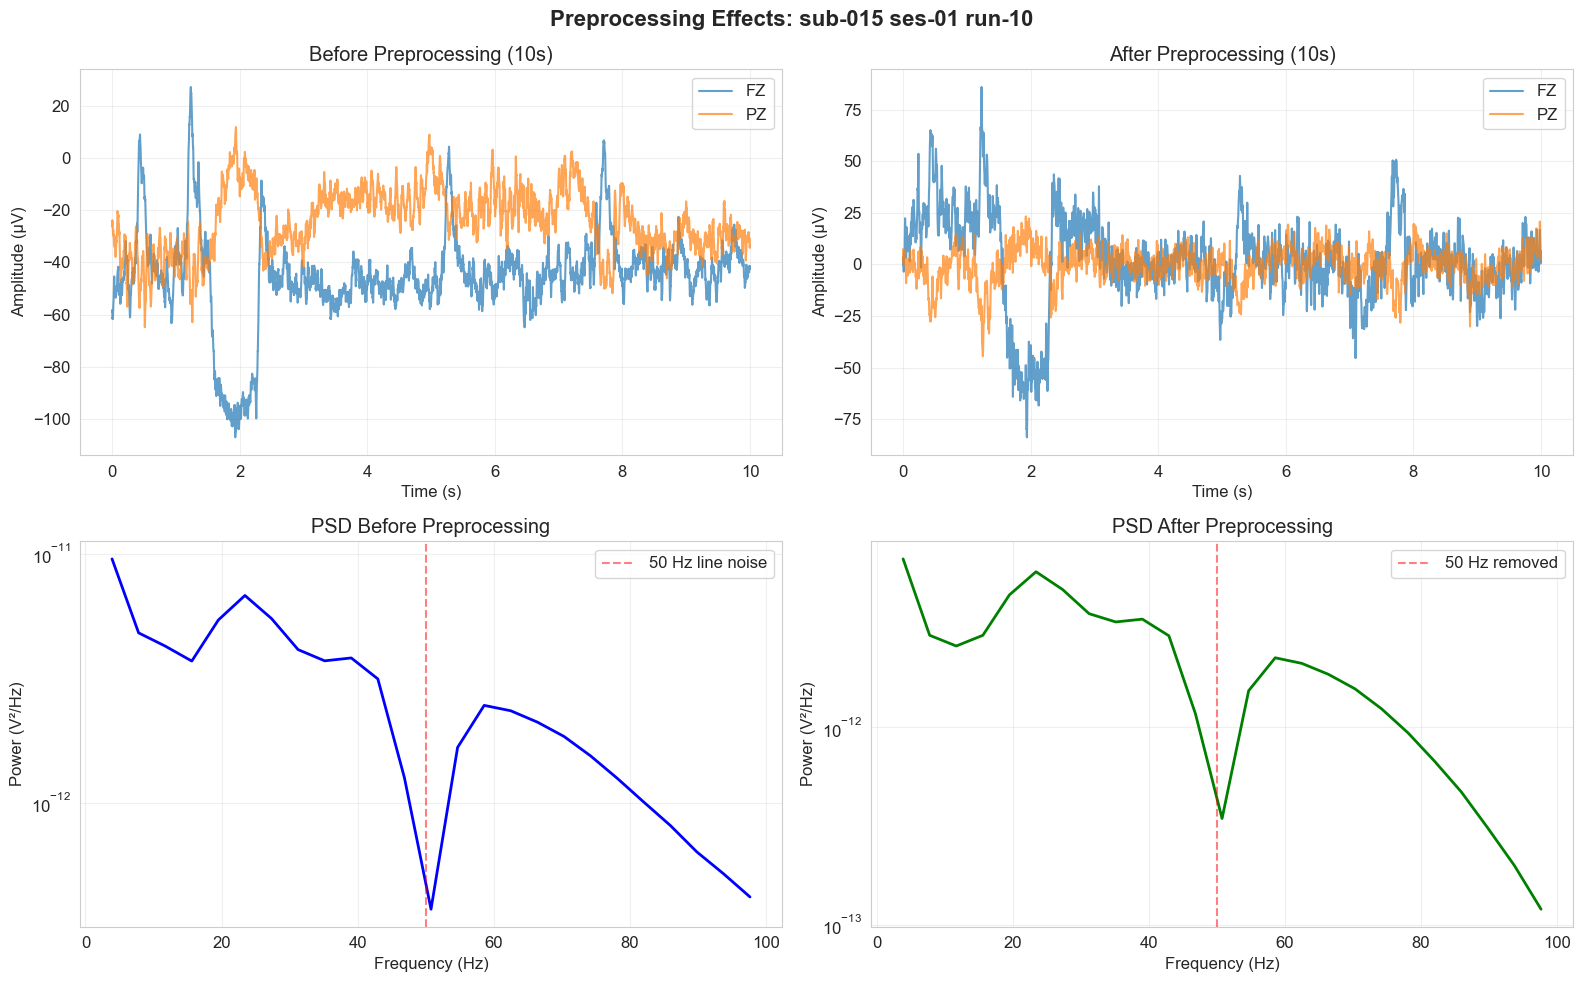


💾 Preprocessing visualization saved to: /Users/leeyelim/Documents/EEG/results/figures/preprocessing_effects_sub-015.png


In [6]:
if preprocessing_results:
    # Select a sample subject
    sample_result = preprocessing_results[0]
    sample_subject = sample_result['subject']
    sample_session = sample_result['session']
    sample_run = sample_result['run']
    
    print(f"\n📊 Visualizing preprocessing effects for {sample_subject} {sample_session} {sample_run}")
    
    # Load raw data
    raw_original = data_loader.load_raw_eeg(sample_subject, session=sample_session, run=sample_run, task='gonogo')
    
    # Load preprocessed data
    reref_path = Path(sample_result['reref_path'])
    raw_preprocessed = mne.io.read_raw_fif(str(reref_path), preload=True, verbose=False)
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'Preprocessing Effects: {sample_subject} {sample_session} {sample_run}', 
                 fontsize=16, fontweight='bold')
    
    # Plot 1: Time series before preprocessing
    ax = axes[0, 0]
    sample_channels = ['FZ', 'PZ'] if all(ch in raw_original.ch_names for ch in ['FZ', 'PZ']) else raw_original.ch_names[:2]
    times = raw_original.times
    end_idx = min(int(10 * raw_original.info['sfreq']), len(times))
    
    for i, ch in enumerate(sample_channels):
        if ch in raw_original.ch_names:
            ch_idx = raw_original.ch_names.index(ch)
            data = raw_original.get_data()[ch_idx, :end_idx] * 1e6
            ax.plot(times[:end_idx], data, label=ch, alpha=0.7)
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude (µV)')
    ax.set_title('Before Preprocessing (10s)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Time series after preprocessing
    ax = axes[0, 1]
    for i, ch in enumerate(sample_channels):
        if ch in raw_preprocessed.ch_names:
            ch_idx = raw_preprocessed.ch_names.index(ch)
            data = raw_preprocessed.get_data()[ch_idx, :end_idx] * 1e6
            ax.plot(times[:end_idx], data, label=ch, alpha=0.7)
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude (µV)')
    ax.set_title('After Preprocessing (10s)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: PSD before preprocessing
    ax = axes[1, 0]
    psds_before, freqs = mne.time_frequency.psd_array_welch(
        raw_original.get_data(picks='eeg'), 
        raw_original.info['sfreq'], 
        fmin=0.5, fmax=100
    )
    ax.semilogy(freqs, np.mean(psds_before, axis=0), 'b-', linewidth=2)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power (V²/Hz)')
    ax.set_title('PSD Before Preprocessing')
    ax.grid(True, alpha=0.3)
    ax.axvline(50, color='red', linestyle='--', alpha=0.5, label='50 Hz line noise')
    ax.legend()
    
    # Plot 4: PSD after preprocessing
    ax = axes[1, 1]
    psds_after, freqs = mne.time_frequency.psd_array_welch(
        raw_preprocessed.get_data(picks='eeg'), 
        raw_preprocessed.info['sfreq'], 
        fmin=0.5, fmax=100
    )
    ax.semilogy(freqs, np.mean(psds_after, axis=0), 'g-', linewidth=2)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power (V²/Hz)')
    ax.set_title('PSD After Preprocessing')
    ax.grid(True, alpha=0.3)
    ax.axvline(50, color='red', linestyle='--', alpha=0.5, label='50 Hz removed')
    ax.legend()
    
    plt.tight_layout()
    
    # Save figure
    fig_path = project_root / 'results' / 'figures'
    fig_path.mkdir(parents=True, exist_ok=True)
    plt.savefig(fig_path / f'preprocessing_effects_{sample_subject}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n💾 Preprocessing visualization saved to: {fig_path / f'preprocessing_effects_{sample_subject}.png'}")

## 7. Next Steps and Completion

In [7]:
if preprocessing_results:
    print("\n🎯 PREPROCESSING PIPELINE COMPLETED")
    print("=" * 60)
    print(f"✅ Successfully preprocessed {len(preprocessing_results)} sessions/runs")
    print(f"✅ Data saved to: {pipeline.preprocessed_dir}")
    print(f"✅ Configuration updated with preprocessing status")
    
    print("\n📋 NEXT STEPS:")
    print(f"1. Run 02_manual_ica_review.ipynb for manual ICA on subject {manual_ica_subject}")
    print("2. Run 03_erp_analysis.ipynb for epoching and ERP computation")
    print("3. Create main_analysis.ipynb for final results and GitHub presentation")
    
    print("\n📊 Analysis Progress: 2/4 Complete")
    print("   ✓ Setup and data exploration")
    print("   ✓ Preprocessing pipeline")
    print("   → Next: Manual ICA review")
    
    # Save preprocessing summary
    df_summary = pd.DataFrame(preprocessing_results)
    summary_stats = {
        'total_sessions': len(df_summary),
        'subjects_processed': df_summary['subject'].nunique(),
        'mean_duration_sec': float(df_summary['duration_sec'].mean()),
        'mean_channels': int(df_summary['n_channels'].mean()),
        'preprocessing_stages': ['filtering', 'line_noise_removal', 'rereferencing'],
        'manual_ica_subject': manual_ica_subject
    }
    
    # Save summary to results
    results_dir = project_root / 'results'
    results_dir.mkdir(parents=True, exist_ok=True)
    
    import json
    with open(results_dir / 'preprocessing_summary.json', 'w') as f:
        json.dump(summary_stats, f, indent=2)
    
    print(f"\n📄 Preprocessing summary saved to: {results_dir / 'preprocessing_summary.json'}")
else:
    print("❌ Preprocessing pipeline failed - no results generated")
    print("Please check the error messages above and try again.")


🎯 PREPROCESSING PIPELINE COMPLETED
✅ Successfully preprocessed 250 sessions/runs
✅ Data saved to: /Users/leeyelim/Documents/EEG/data/preprocessed
✅ Configuration updated with preprocessing status

📋 NEXT STEPS:
1. Run 02_manual_ica_review.ipynb for manual ICA on subject sub-003
2. Run 03_erp_analysis.ipynb for epoching and ERP computation
3. Create main_analysis.ipynb for final results and GitHub presentation

📊 Analysis Progress: 2/4 Complete
   ✓ Setup and data exploration
   ✓ Preprocessing pipeline
   → Next: Manual ICA review

📄 Preprocessing summary saved to: /Users/leeyelim/Documents/EEG/results/preprocessing_summary.json
